In [1]:
import new_model as model_mobster_mv
import numpy as np
import pandas as pd
import pyro.distributions as dist
import torch

import matplotlib.pyplot as plt

from utils.plot_functions import *
from utils.BoundedPareto import BoundedPareto
from utils.create_beta_pareto_dataset import *

%load_ext autoreload
%autoreload 2

c:\Users\Administrator\miniconda3\envs\mobster\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Approximated dirac delta
Beta distribution with $a <<$ and $b>>$

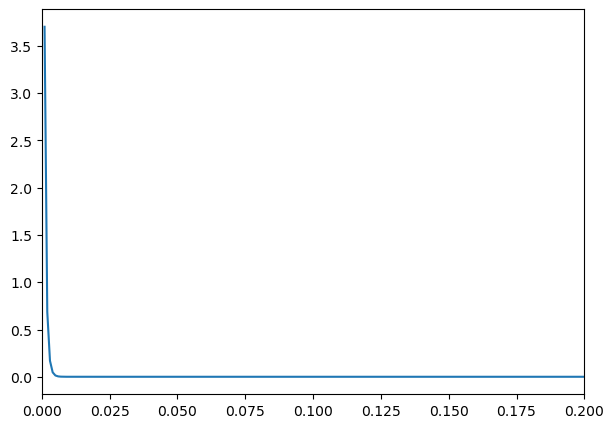

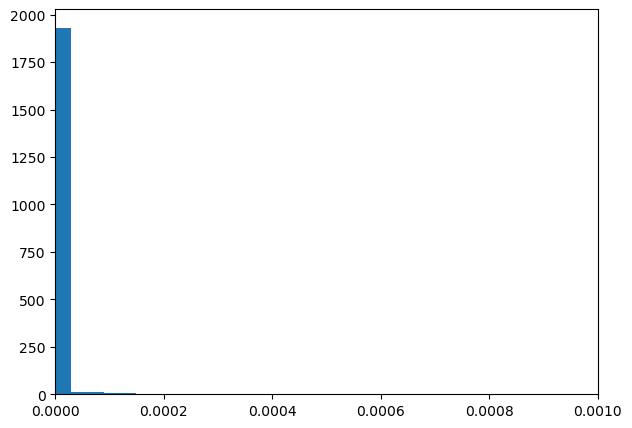

In [2]:
x = np.linspace(0.001, 0.999, 1000)
a_beta = 0.01
b_beta = 1000
pdf = beta.pdf(x, a_beta, b_beta)

plt.figure(figsize=(7, 5))
plt.xlim([0,0.2])
plt.plot(x, pdf,linewidth=1.5)


plt.figure(figsize=(7, 5))
samples = dist.Beta(a_beta, b_beta).sample([2000])
plt.xlim([0,0.001])
plt.hist(samples, bins = 50);

Exponential distribution with $\lambda >>$

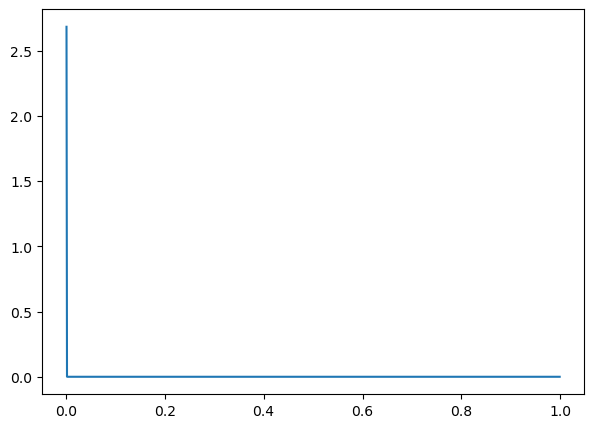

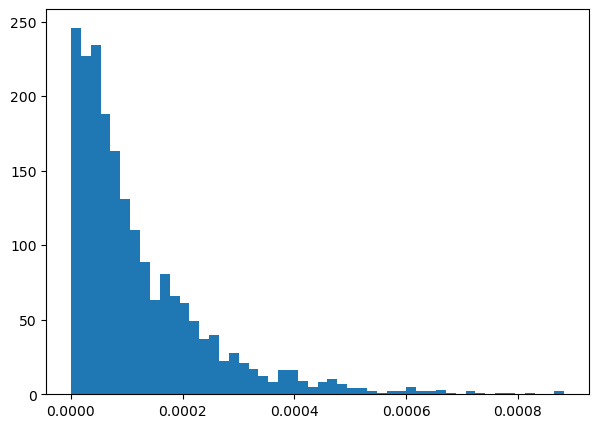

In [3]:
x = np.linspace(0.001, 0.999, 1000)
rate = 8000
pdf = expon.pdf(x, scale = 1/rate)

plt.figure(figsize=(7, 5))
# plt.xlim([0,0.2])
plt.plot(x, pdf,linewidth=1.5)


plt.figure(figsize=(7, 5))
samples = dist.Exponential(rate).sample([2000])
# plt.xlim([0,0.001])
plt.hist(samples, bins = 50);

### Reconstructed rRACES multisample data

In [34]:
N1 = 500
N2 = 500
N3 = 500
N4 = 500
N5 = 500
N6 = 500
seed = 123
# Component 1
phi_beta_x = 0.5
k_beta_x = 300
phi_beta_y = 0.5
k_beta_y= 300
n1=100
NV1, DP1 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n1, N=N1, seed=seed)


# Component 2
phi_beta_x = 0.5
k_beta_x = 300
phi_beta_y = 1e-10
k_beta_y= 300
n2=100
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV2[:,1] = torch.tensor(0, dtype=NV2.dtype)
NV = torch.concat((NV1,NV2))
DP = torch.concat((DP1,DP2))

# Component 3
phi_beta_x = 0.2
k_beta_x = 300
phi_beta_y = 1e-10
k_beta_y= 300
n3=100
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV3[:,1] = torch.tensor(0, dtype=NV3.dtype)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))


# Component 4
phi_beta_x = 1e-10
k_beta_x = 300
phi_beta_y = 0.4
k_beta_y= 150
n4=100
NV4, DP4 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n4, N=N4, seed=seed)
NV4[:,0] = torch.tensor(0, dtype=NV4.dtype)
NV = torch.concat((NV,NV4))
DP = torch.concat((DP,DP4))


# Component 5
L_pareto = 0.05
H_pareto = 0.5
alpha_pareto = 1.5
phi_beta = 1e-10
k_beta = 300
n5=100
NV5, DP5 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n5, N=N5,exchanged = False, seed = seed)
NV5[:,1] = torch.tensor(0, dtype=NV1.dtype)
NV = torch.concat((NV,NV5))
DP = torch.concat((DP,DP5))
print(NV.shape)
print(DP.shape)


# Component 6
alpha_pareto = 1.5
phi_beta = 1e-10
k_beta = 300
n6=100
NV6, DP6 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n5, N=N5, exchanged = True, seed = seed)
NV6[:,0] = torch.tensor(0, dtype=NV6.dtype)
NV = torch.concat((NV,NV6))
DP = torch.concat((DP,DP6))

torch.Size([2500, 2])
torch.Size([2500, 2])


In [35]:
def get_a_beta(phi, kappa):
    return phi * (kappa)

def get_b_beta(phi, kappa):
    return (1-phi) * (kappa)

In [36]:
print(NV)
print("Exponential:\n", dist.Exponential(rate).log_prob(NV))

phi = 0.5
kappa = 300
a = get_a_beta(phi,kappa)
b = get_b_beta(phi,kappa)
print("BetaBinomial:\n", dist.BetaBinomial(a,b, total_count=DP).log_prob(NV))

print("Binomial (tail):\n", dist.Binomial(total_count=DP, probs = 0.01).log_prob(NV))

tensor([[44., 49.],
        [46., 56.],
        [52., 56.],
        ...,
        [ 0., 11.],
        [ 0.,  4.],
        [ 0.,  4.]])
Exponential:
 tensor([[-3.5199e+05, -3.9199e+05],
        [-3.6799e+05, -4.4799e+05],
        [-4.1599e+05, -4.4799e+05],
        ...,
        [ 8.9872e+00, -8.7991e+04],
        [ 8.9872e+00, -3.1991e+04],
        [ 8.9872e+00, -3.1991e+04]])
BetaBinomial:
 tensor([[ -3.2090,  -2.6898],
        [ -2.9120,  -3.2090],
        [ -2.7341,  -3.2090],
        ...,
        [-56.7930, -29.2013],
        [-56.7930, -43.5744],
        [-56.7930, -43.5744]])
Binomial (tail):
 tensor([[-137.1210, -159.4019],
        [-145.9139, -192.2625],
        [-173.2467, -192.2625],
        ...,
        [  -1.0050,  -18.9671],
        [  -1.0050,   -4.2036],
        [  -1.0050,   -4.2036]])


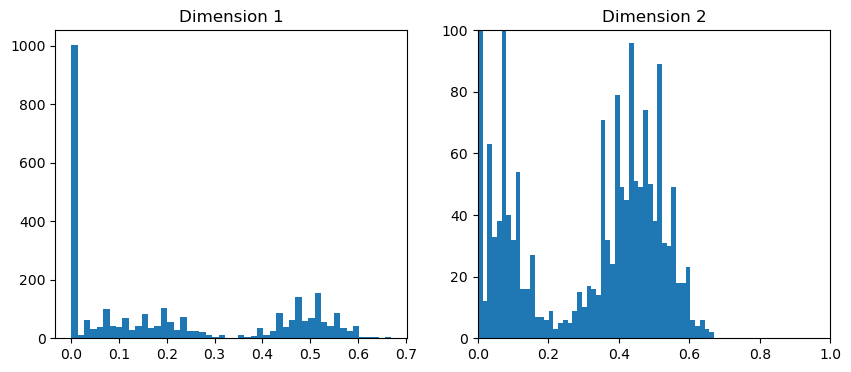

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")
plt.xlim([0,1])
plt.ylim([0,100])

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.xlim([0,1])
plt.ylim([0,100])
plt.show()

In [38]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))
labels_3 = np.ones(N3)*2
labels = np.concatenate((labels, labels_3))
labels_4 = np.ones(N4)*3
labels = np.concatenate((labels, labels_4))
labels_5 = np.ones(N5)*4
labels = np.concatenate((labels, labels_5))
labels_6 = np.ones(N6)*5
labels = np.concatenate((labels, labels_6))

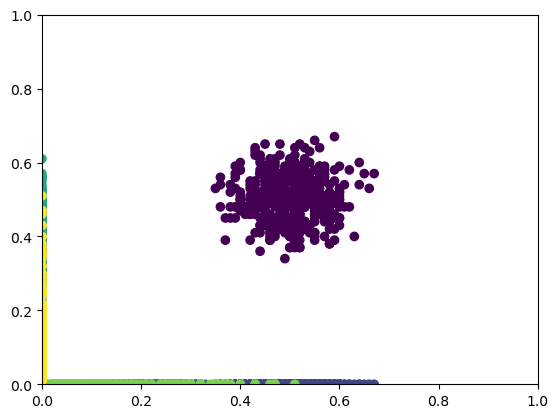

In [39]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

In [40]:
# def log_prob(self, x):
    #     is_valid = (x >= self.scale) & (x <= self.upper_limit)
    #     log_prob = self.propose.log_prob(x)
    #     # Set log probability to -inf for invalid values
    #     log_prob[~is_valid] = -float('inf')
    #     return log_prob

In [41]:
BoundedPareto(scale = 0.05, alpha = 2, upper_limit = 0.5).log_prob(torch.tensor(1e-10))

tensor(-inf)

No GPU available. Training will run on CPU.
RUN WITH K = 6 AND SEED = 41
Minimum detected VAF: tensor(0.0100)


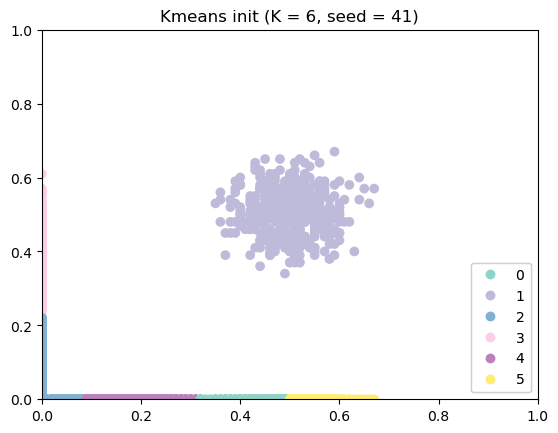

tensor([[2.1040e-01, 1.0431e-07],
        [4.9860e-01, 5.0390e-01],
        [4.9706e-01, 1.1921e-07],
        [1.0000e-10, 3.9998e-01],
        [1.0000e-10, 9.0467e-02],
        [8.2927e-02, 1.0431e-07]])
Pareto lk tensor([[-1.4877,    -inf],
        [-3.2133, -3.2344],
        [-3.2071,    -inf],
        [   -inf, -2.7725],
        [   -inf,  0.2004],
        [ 0.3744,    -inf]])
Beta lk tensor([[   2.8053, -559.7566],
        [   2.6079,    2.6079],
        [   2.5771, -554.0815],
        [-855.1288,    2.6288],
        [-855.1288,   -1.9272],
        [  -3.5989, -559.7566]])
Exp lk tensor([[-1674.2374,     8.9864],
        [-3979.8127, -4022.2112],
        [-3967.5291,     8.9862],
        [    8.9872, -3190.8616],
        [    8.9872,  -714.7489],
        [ -654.4310,     8.9864]])
tensor([-1.4877e+00,  2.8053e+00, -1.6742e+03])
tensor([1, 0, 2])
tensor([     -inf, -559.7566,    8.9864])
tensor([2, 1, 0])
tensor([-3.2133e+00,  2.6079e+00, -3.9798e+03])
tensor([1, 0, 2])
tensor([-3.

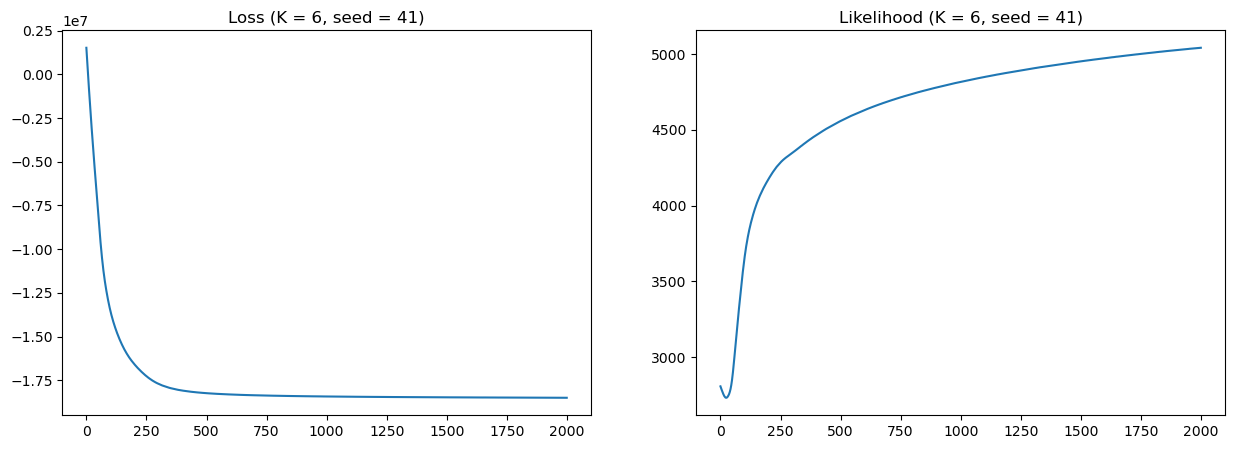

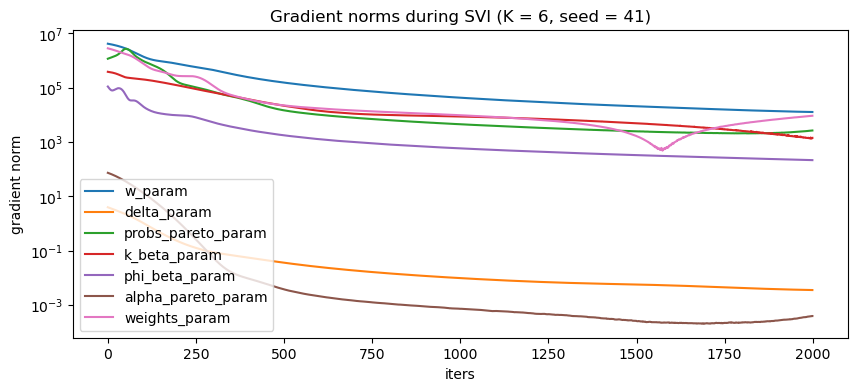

Inference lk:  5041.9375
Final lk (integr):  tensor(-3503.5461, grad_fn=<SumBackward0>)
INTEGR: 
n_params:  126
n:  tensor(3000)
lk:  tensor(-3503.5461, grad_fn=<SumBackward0>)
bic: 8015.89453125 

Weights:  [0.32290596 0.31214448 0.00679502 0.03015126 0.09899466 0.22900862]


c:\Users\Administrator\Documents\Università\Tesi magistrale\subclonal_deconvolution_mv\new_model.py:756: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = plt.scatter(NV_S1/DP_S1, NV_S2/DP_S2, c=colors, cmap = 'Set3') # tab10


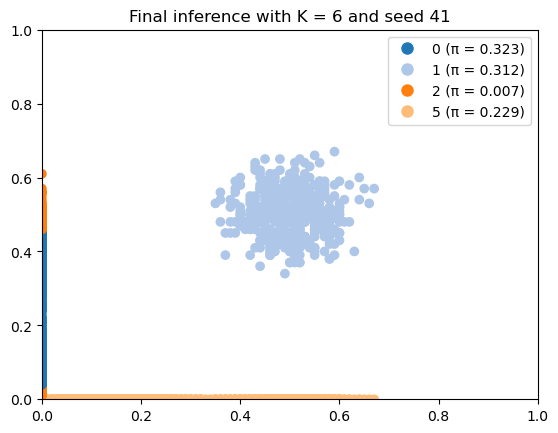

c:\Users\Administrator\miniconda3\envs\mobster\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


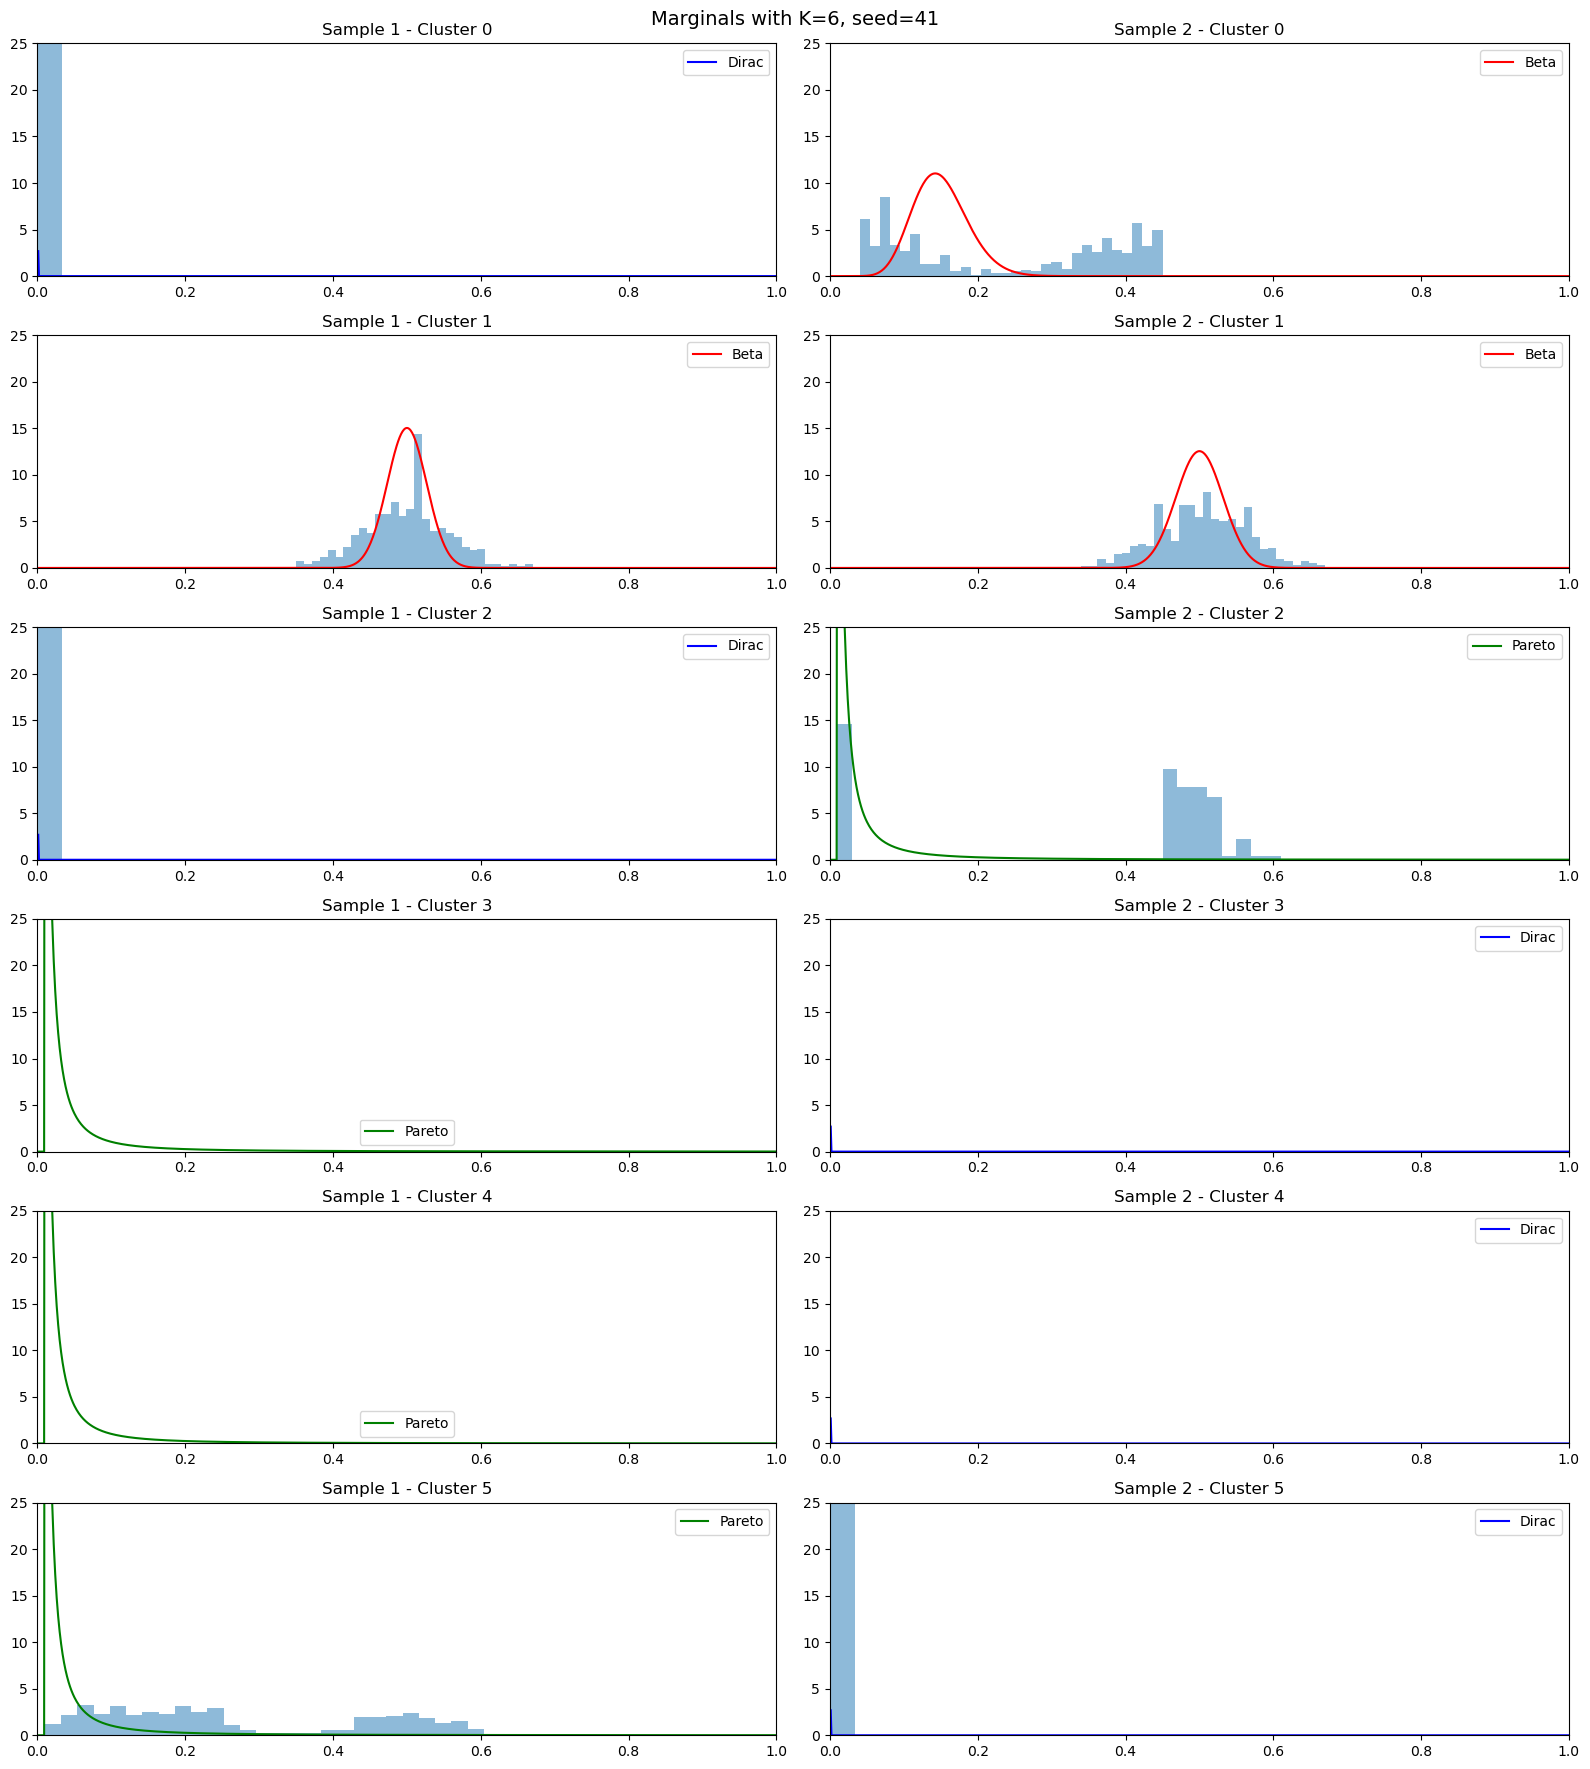

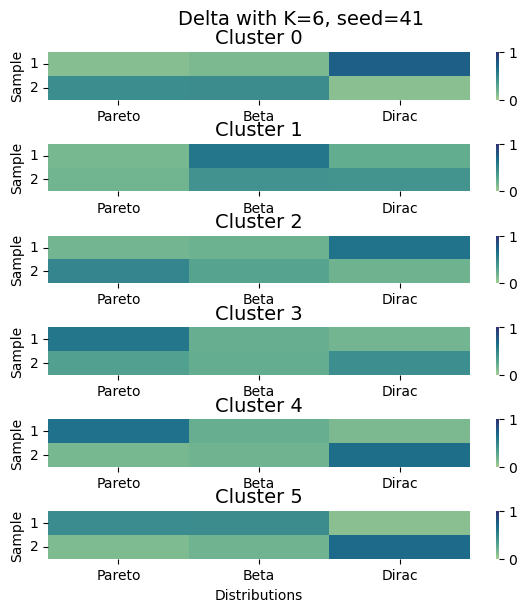

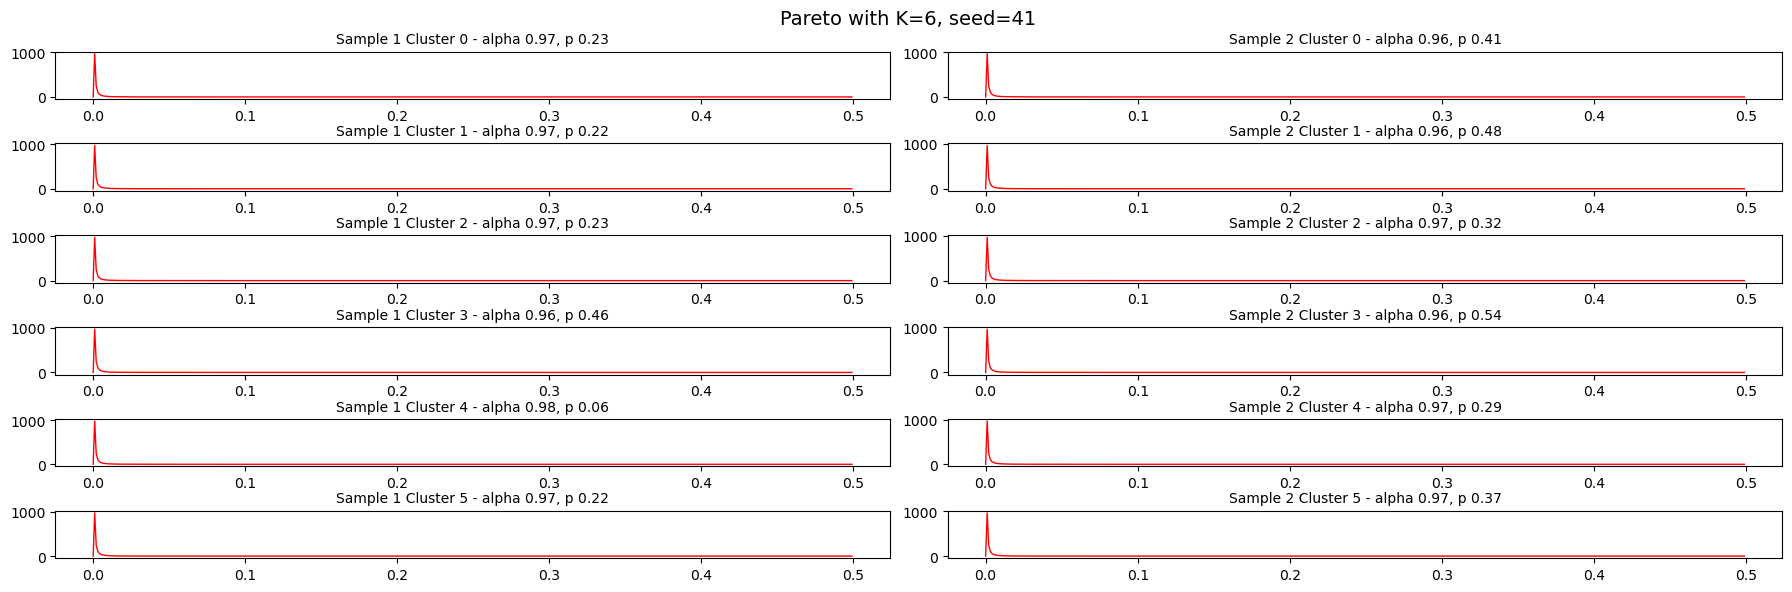

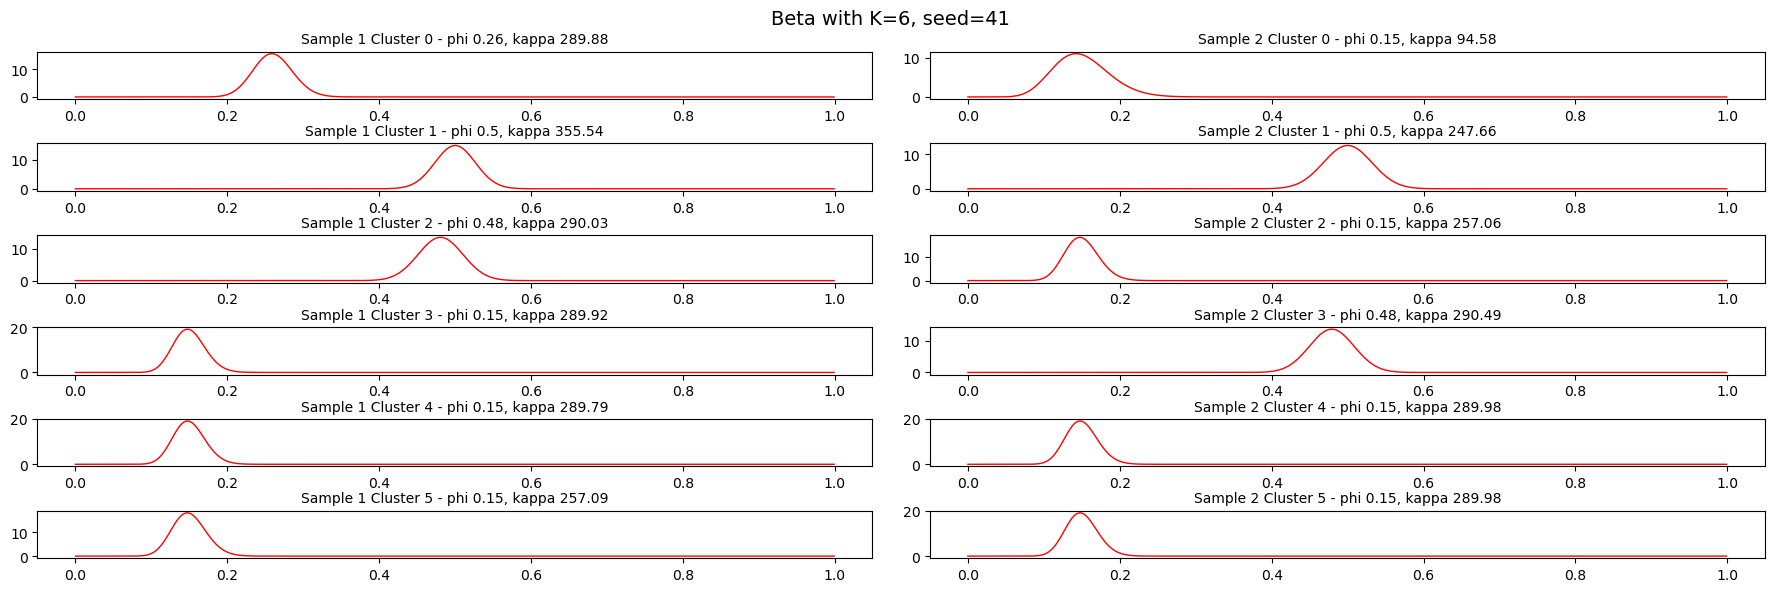

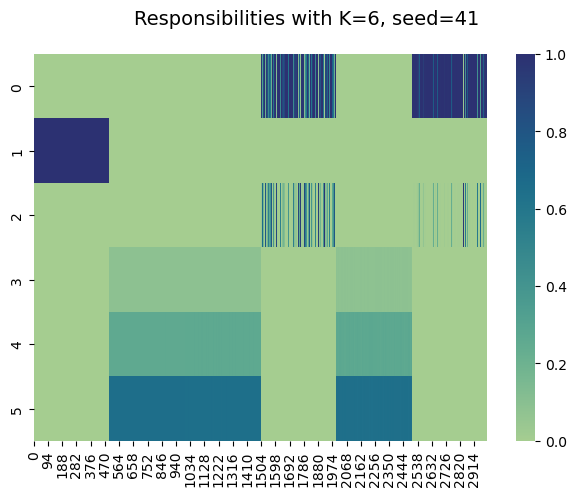

Selected number of clusters is 6 with seed 41


In [47]:
K_list = [6]
seed_list = [41]
mb_list, best_K, best_seed = model_mobster_mv.fit(NV, DP, num_iter = 2000, K = K_list, seed = seed_list, lr = 0.01)

In [13]:
mb_list[0].params['delta_param']

tensor([[[0.1311, 0.0926, 0.7763],
         [0.3382, 0.3944, 0.2674]],

        [[0.2878, 0.4240, 0.2882],
         [0.2036, 0.1544, 0.6420]],

        [[0.4423, 0.2976, 0.2601],
         [0.2516, 0.4854, 0.2630]],

        [[0.2634, 0.5111, 0.2255],
         [0.3224, 0.0811, 0.5965]],

        [[0.1382, 0.1862, 0.6756],
         [0.3210, 0.4338, 0.2451]]], grad_fn=<DivBackward0>)

In [10]:
NV[np.where(mb_list[0].params['cluster_assignments'] == 5)]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

### Reconstructed rRACES longitudinal data 

In [5]:
N1 = 80
N2 = 80
N3 = 80
N4 = 80
N5 = 400
N6 = 400
seed = 123
# Component 1
alpha_pareto = 1.2
L_pareto = 0.01
H_pareto = 0.5
phi_beta = 0.5
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)


# Component 2
phi_beta_x = 0.5
k_beta_x = 150
phi_beta_y = 0.5
k_beta_y= 150
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
DP = torch.concat((DP1,DP2))

# Component 3
phi_beta_x = 0.25
k_beta_x = 100
phi_beta_y = 1e-10
k_beta_y= 100
n3=150
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV3[:,1] = torch.tensor(0, dtype=NV3.dtype)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))


# Component 4
phi_beta_x = 1e-10
k_beta_x = 150
phi_beta_y = 0.25
k_beta_y= 150
n4=150
NV4, DP4 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n4, N=N4, seed=seed)
NV4[:,0] = torch.tensor(0, dtype=NV4.dtype)
NV = torch.concat((NV,NV4))
DP = torch.concat((DP,DP4))


# Component 5
alpha_pareto = 1.5
phi_beta = 1e-10
k_beta = 150
n5=150
NV5, DP5 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n5, N=N5,exchanged = False, seed = seed)
NV5[:,1] = torch.tensor(0, dtype=NV1.dtype)
NV = torch.concat((NV,NV5))
DP = torch.concat((DP,DP5))
print(NV.shape)
print(DP.shape)


# Component 6
alpha_pareto = 1.5
phi_beta = 1e-10
k_beta = 150
n6=150
NV6, DP6 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n5, N=N5, exchanged = True, seed = seed)
NV6[:,0] = torch.tensor(0, dtype=NV6.dtype)
NV = torch.concat((NV,NV6))
DP = torch.concat((DP,DP6))

torch.Size([720, 2])
torch.Size([720, 2])


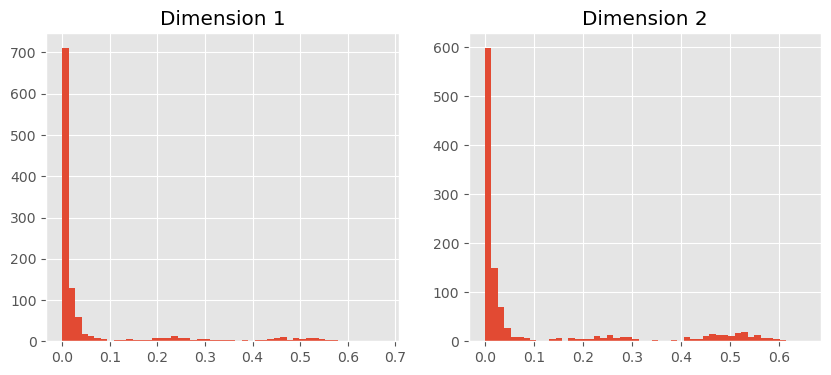

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [9]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))
labels_3 = np.ones(N3)*2
labels = np.concatenate((labels, labels_3))
labels_4 = np.ones(N4)*3
labels = np.concatenate((labels, labels_4))
labels_5 = np.ones(N5)*4
labels = np.concatenate((labels, labels_5))
labels_6 = np.ones(N6)*5
labels = np.concatenate((labels, labels_6))

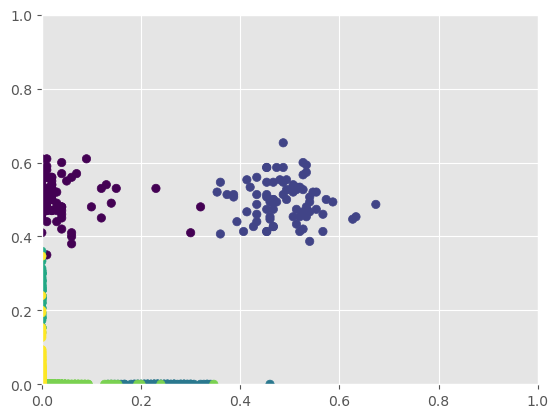

In [10]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

RUN WITH K = 5 AND SEED = 40
NV = 0 before: tensor(1053)
delta_param tensor([[[0.3992, 0.6008],
         [0.6043, 0.3957]],

        [[0.4042, 0.5958],
         [0.4043, 0.5957]],

        [[0.4041, 0.5959],
         [0.4043, 0.5957]],

        [[0.3960, 0.6040],
         [0.6046, 0.3954]],

        [[0.5994, 0.4006],
         [0.3953, 0.6047]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 9654021.220826149
Iteration 200: Loss = 9367152.824601173
Iteration 400: Loss = 7481357.677445412
Iteration 600: Loss = 9627810.784623146
Iteration 800: Loss = 7851566.806962013
Iteration 1000: Loss = 7838936.966996193
Iteration 1200: Loss = 7925623.105912209
Iteration 1400: Loss = 7322845.545609474
Iteration 1600: Loss = 7047449.958451271
Iteration 1800: Loss = 7935721.141068459
Iteration 2000: Loss = 7161458.272904396
Iteration 2200: Loss = 7110062.566117287
Iteration 2400: Loss = 7008516.839066505
Iteration 2600: Loss = 8021738.026566505
Iteration 2800: Loss = 8112688.485795021


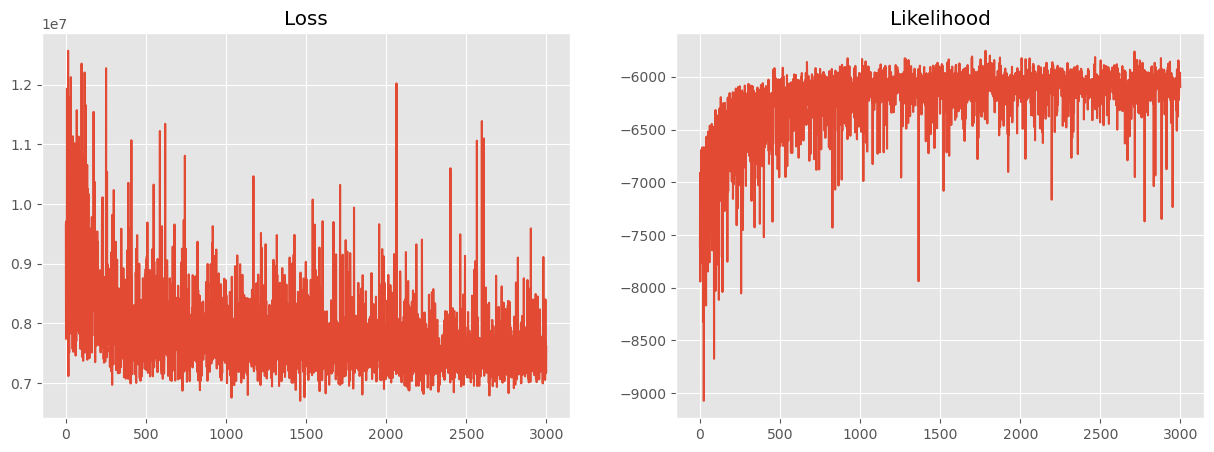

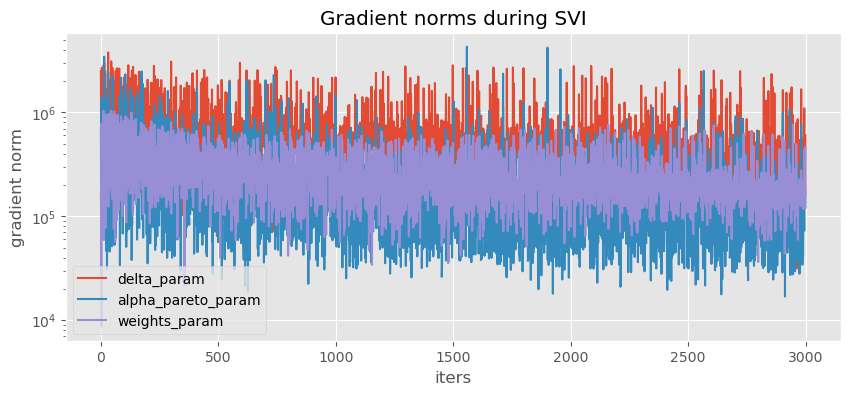

bic:  tensor(72828.2031, grad_fn=<RsubBackward1>)


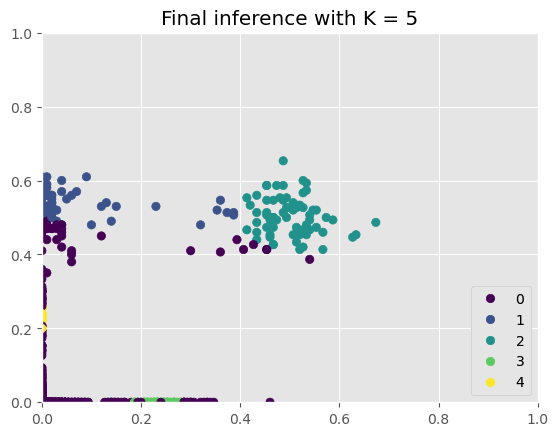

RUN WITH K = 5 AND SEED = 41
NV = 0 before: tensor(1053)
delta_param tensor([[[0.4041, 0.5959],
         [0.6040, 0.3960]],

        [[0.3993, 0.6007],
         [0.4006, 0.5994]],

        [[0.4009, 0.5991],
         [0.3962, 0.6038]],

        [[0.4006, 0.5994],
         [0.6042, 0.3958]],

        [[0.6040, 0.3960],
         [0.3993, 0.6007]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 10695384.230294228
Iteration 200: Loss = 10507391.818985939
Iteration 400: Loss = 8418031.268143654
Iteration 600: Loss = 7846247.978714943
Iteration 800: Loss = 8434046.187821388
Iteration 1000: Loss = 7407747.862626076
Iteration 1200: Loss = 8173099.833695412
Iteration 1400: Loss = 7088856.502640724
Iteration 1600: Loss = 7598677.297318459
Iteration 1800: Loss = 7746735.603714943
Iteration 2000: Loss = 7399972.744095802
Iteration 2200: Loss = 7678873.084671974
Iteration 2400: Loss = 7566512.968949318
Iteration 2600: Loss = 7695179.449662209
Iteration 2800: Loss = 7200892.668656349


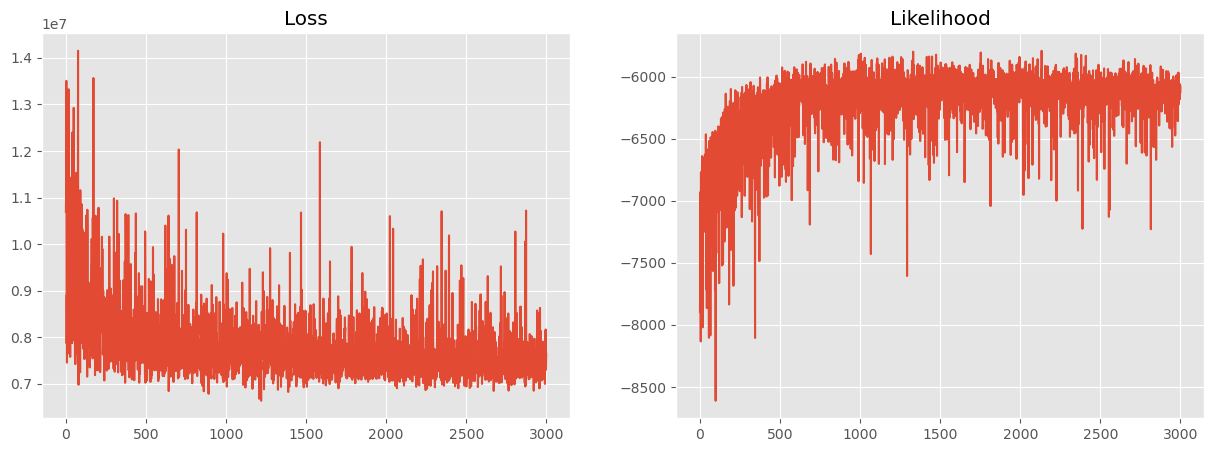

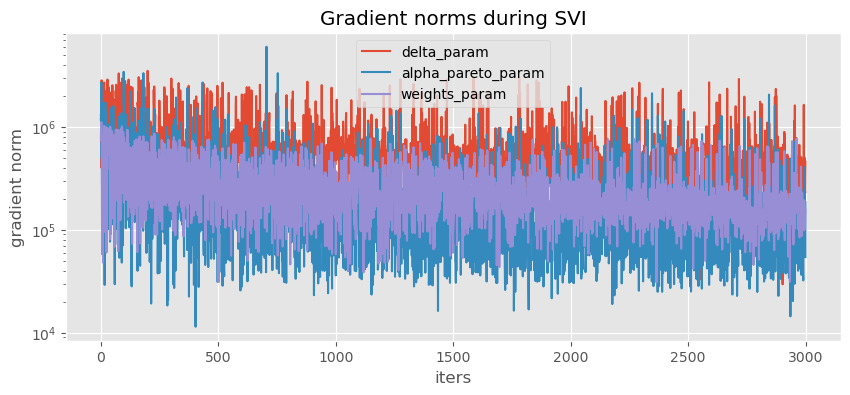

bic:  tensor(72856.3750, grad_fn=<RsubBackward1>)


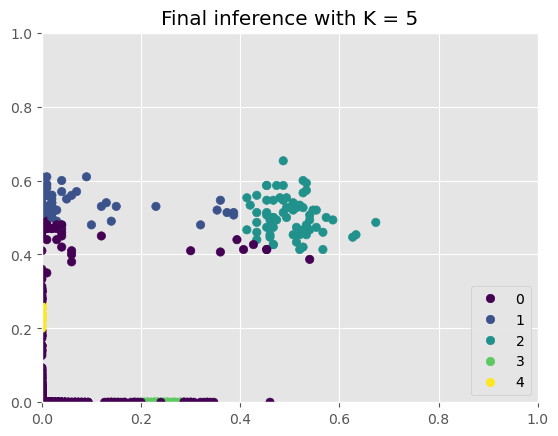

Selected number of clusters is 5 with seed 40


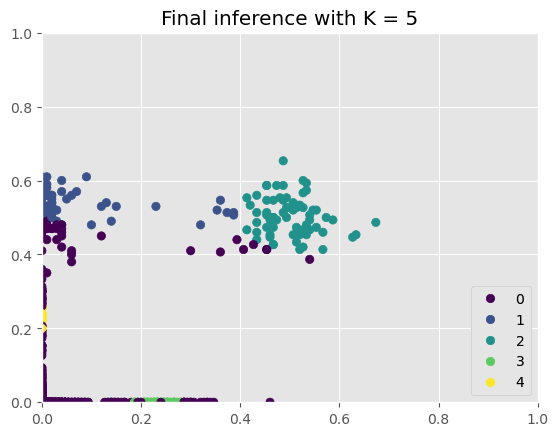

In [11]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [5], seed = [40,41], lr = 0.005)

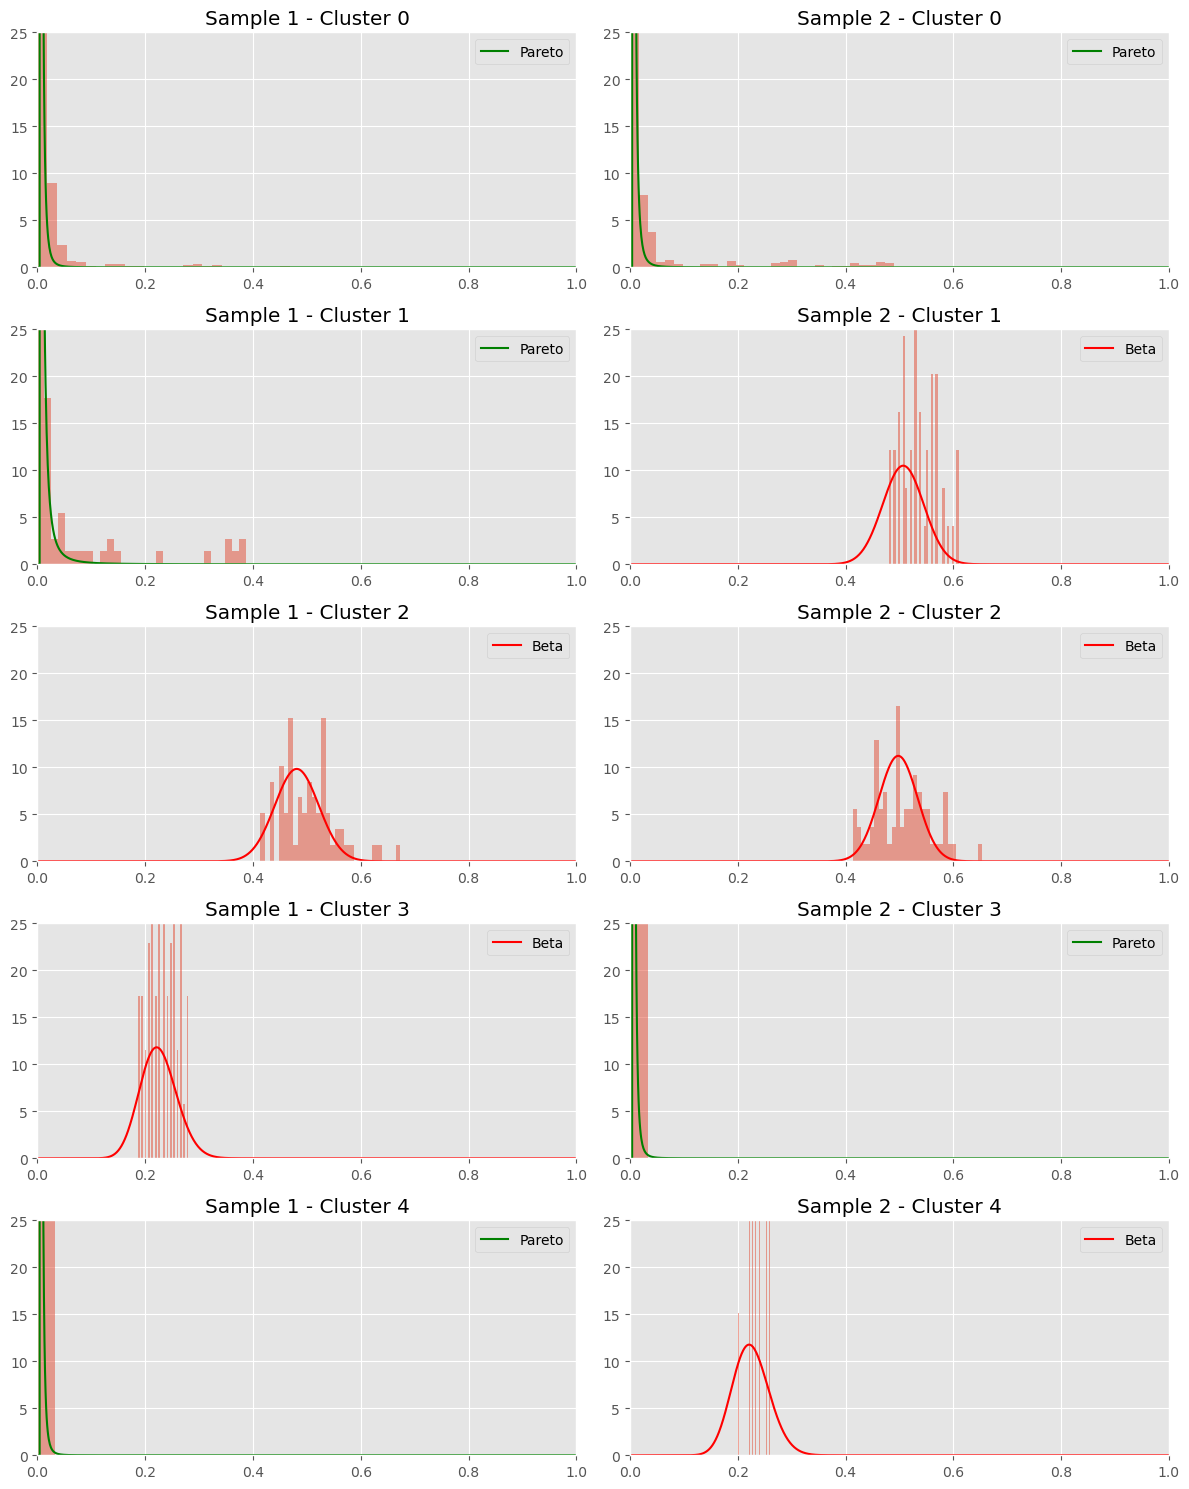

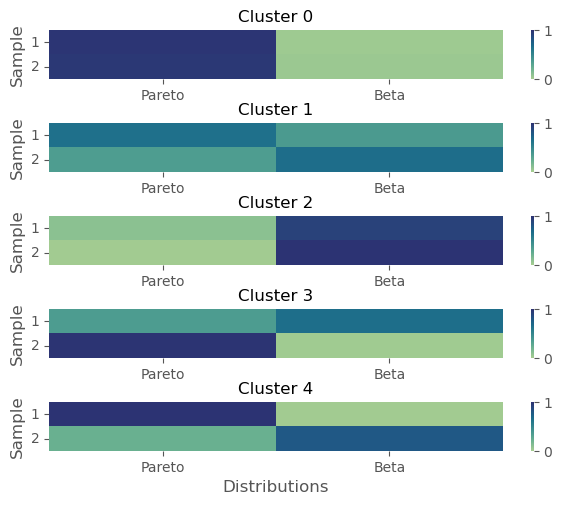

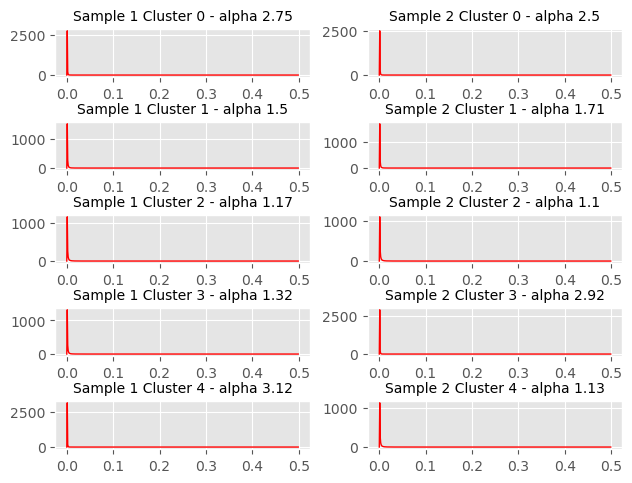

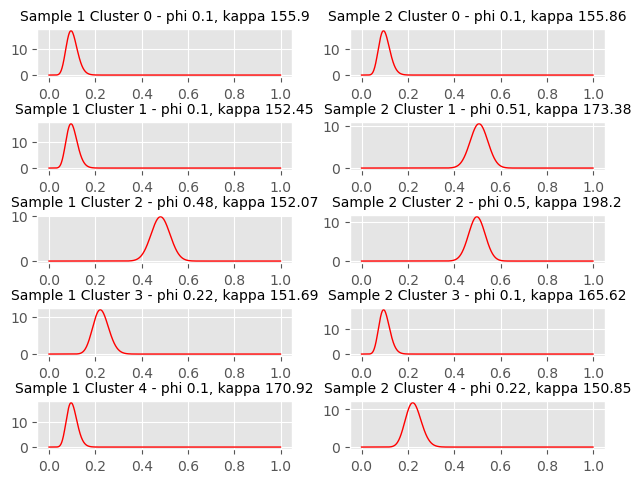

In [14]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [15]:
final_mb.params

{'weights_param': tensor([0.5100, 0.1151, 0.0874, 0.1550, 0.1324], dtype=torch.float64,
        grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[2.7466, 2.5024],
         [1.5048, 1.7101],
         [1.1652, 1.0987],
         [1.3189, 2.9221],
         [3.1201, 1.1291]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.1000, 0.1000],
         [0.1000, 0.5069],
         [0.4813, 0.4978],
         [0.2247, 0.1000],
         [0.1000, 0.2248]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[155.8959, 155.8638],
         [152.4528, 173.3756],
         [152.0714, 198.1994],
         [151.6937, 165.6187],
         [170.9223, 150.8453]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.9734, 0.0266],
          [0.9623, 0.0377]],
 
         [[0.6389, 0.3611],
          [0.3413, 0.6587]],
 
         [[0.0928, 0.9072],
          [0.0155, 0.9845]],
 
         [[0.3500, 0.6500],
          [0.9808, 0.0192]],
 
         [[0.9848, 0.0152],
          [0.2176, 0.7824]]], grad_fn=<Di

### rRACES data

In [11]:
NV_r = pd.read_csv("./rRACES_data/NV2.csv")
DP_r = pd.read_csv("./rRACES_data/DP2.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

FileNotFoundError: [Errno 2] No such file or directory: './rRACES_data/NV2.csv'

In [7]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0097)
tensor(0.0092)


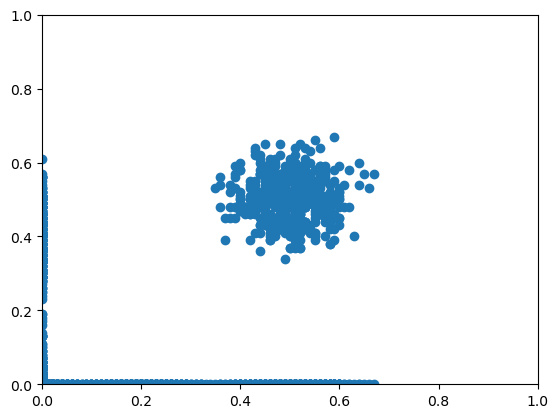

In [12]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

In [13]:
torch.sum((NV[:,0] == 0) & (NV[:,1]/DP[:,1] < 0.18))

tensor(585)

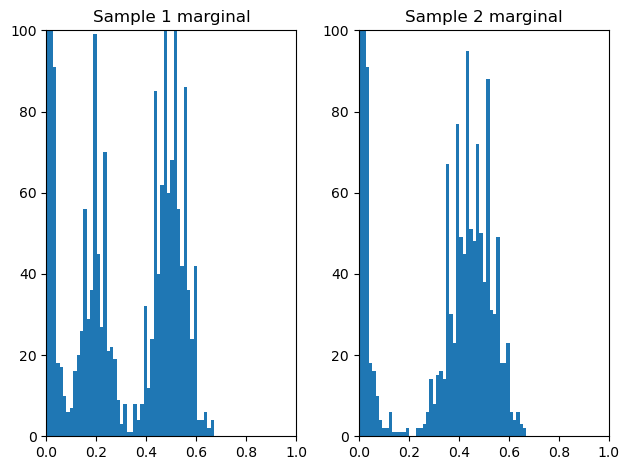

In [14]:
# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[4.9860e-01, 5.0390e-01],
        [1.0810e-02, 1.2115e-02],
        [4.9878e-01, 1.6391e-07],
        [7.1526e-07, 4.0264e-01],
        [2.0169e-01, 1.0000e-03]])
Cluster Sizes: [500 988 500 503 509]
Cluster Sizes Vector: [0.16666667 0.32933333 0.16666667 0.16766667 0.16966667]
Cluster variances [[ 151.07040603  151.07040603]
 [1137.16010595 1137.16010595]
 [ 328.74064707  328.74064707]
 [ 260.1387847   260.1387847 ]
 [ 478.76734762  478.76734762]]


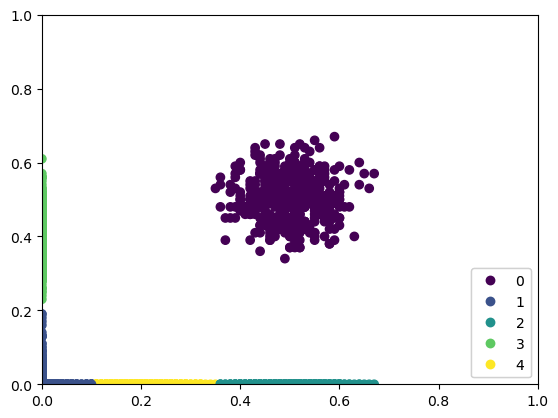

In [ ]:
from sklearn.cluster import KMeans
K = 5
kmeans = KMeans(n_clusters=K, random_state=123, n_init=2).fit((NV/DP).numpy())
labels = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

plt.xlim([0,1])
plt.ylim([0,1])
sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)
legend1 = plt.legend(*sc.legend_elements(), loc="lower right")
plt.gca().add_artist(legend1)

# print(labels.astype(int))
# Compute cluster sizes
cluster_sizes = np.bincount(labels.astype(int), minlength=K)
print("Cluster Sizes:", cluster_sizes)

# Convert to a 1D vector
cluster_sizes_vector = cluster_sizes.reshape(-1)/np.sum(cluster_sizes.reshape(-1))
print("Cluster Sizes Vector:", cluster_sizes_vector)

centroids = kmeans.cluster_centers_
variances = []
for i in range(kmeans.n_clusters):
    vaf = NV/DP
    points_in_cluster = vaf[labels == i]
    
    # Get the centroid of the current cluster
    centroid = centroids[i]

    # Calculate the squared distances of points to the centroid
    distances = np.linalg.norm(points_in_cluster - centroid, axis=1) ** 2

    # Compute the variance (mean of squared distances)
    cluster_variance = np.mean(distances)
    variances.append(cluster_variance)

kappas = [1 / variance if variance > 0 else np.inf for variance in variances]
kappas = np.tile(kappas, (NV.shape[1], 1)).T
print("Cluster variances", kappas)

No GPU available. Training will run on CPU.
RUN WITH K = 5 AND SEED = 41
Minimum detected VAF: tensor(0.0100)
tensor([[[0.0422, 0.8085, 0.1492],
         [0.3199, 0.0801, 0.5999]],

        [[0.3487, 0.0128, 0.6385],
         [0.2294, 0.0761, 0.6945]],

        [[0.8369, 0.1334, 0.0297],
         [0.1824, 0.7358, 0.0819]],

        [[0.2208, 0.7215, 0.0577],
         [0.3092, 0.0881, 0.6027]],

        [[0.1755, 0.6874, 0.1371],
         [0.0197, 0.4465, 0.5337]]], grad_fn=<DivBackward0>)
tensor([[[0.0429, 0.8054, 0.1517],
         [0.3238, 0.0811, 0.5951]],

        [[0.3532, 0.0129, 0.6339],
         [0.2326, 0.0772, 0.6902]],

        [[0.8341, 0.1357, 0.0302],
         [0.1851, 0.7319, 0.0831]],

        [[0.2240, 0.7174, 0.0586],
         [0.3129, 0.0892, 0.5979]],

        [[0.1779, 0.6831, 0.1390],
         [0.0201, 0.4464, 0.5335]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 4051002.064599037
tensor([[[0.0436, 0.8023, 0.1541],
         [0.3276, 0.0820, 0.5903]],

        [[0.

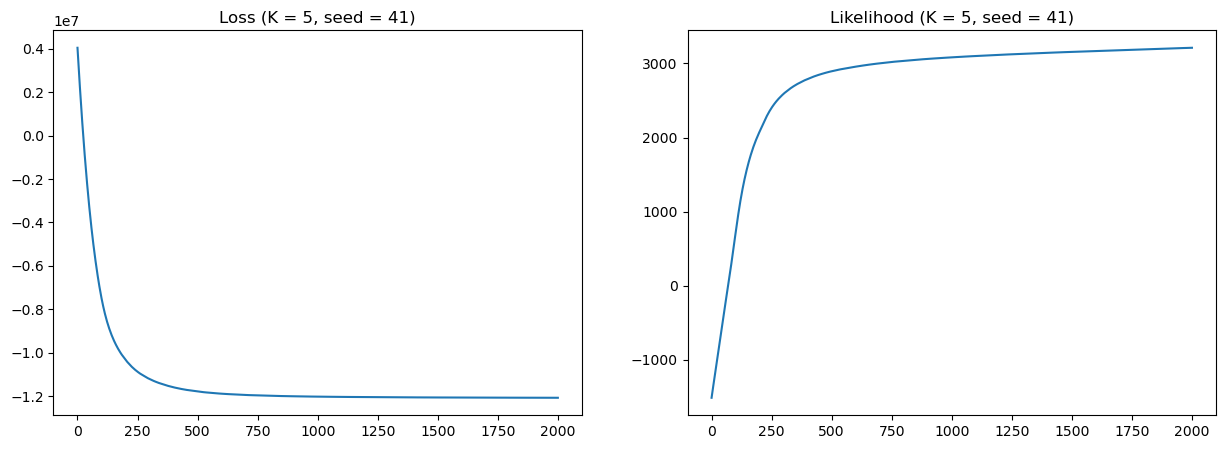

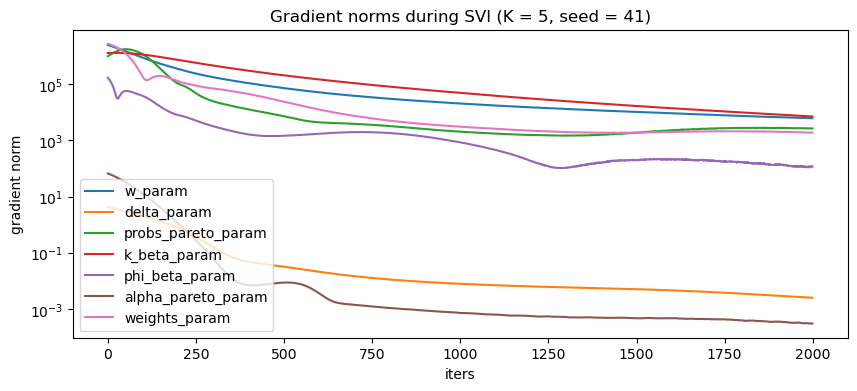

Inference lk:  3210.4958
Final lk (integr):  tensor(-1.1695e+08, grad_fn=<SumBackward0>)
INTEGR: 
n_params:  105
n:  tensor(3000)
lk:  tensor(-1.1695e+08, grad_fn=<SumBackward0>)
bic: 233902976.0 

Weights:  [0.15340945 0.31924124 0.34015438 0.01496132 0.1722336 ]


c:\Users\Administrator\Documents\Università\Tesi magistrale\subclonal_deconvolution_mv\new_model.py:742: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = plt.scatter(NV_S1/DP_S1, NV_S2/DP_S2, c=colors, cmap = 'Set3') # tab10


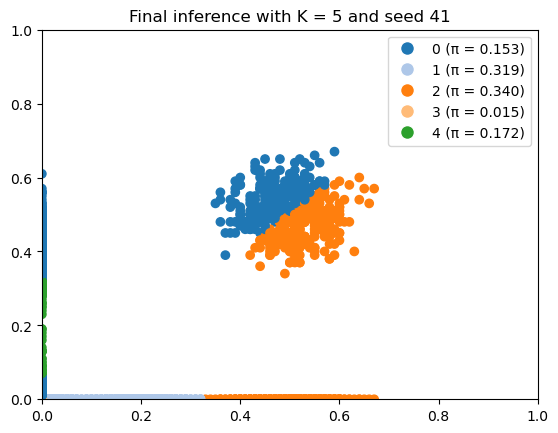

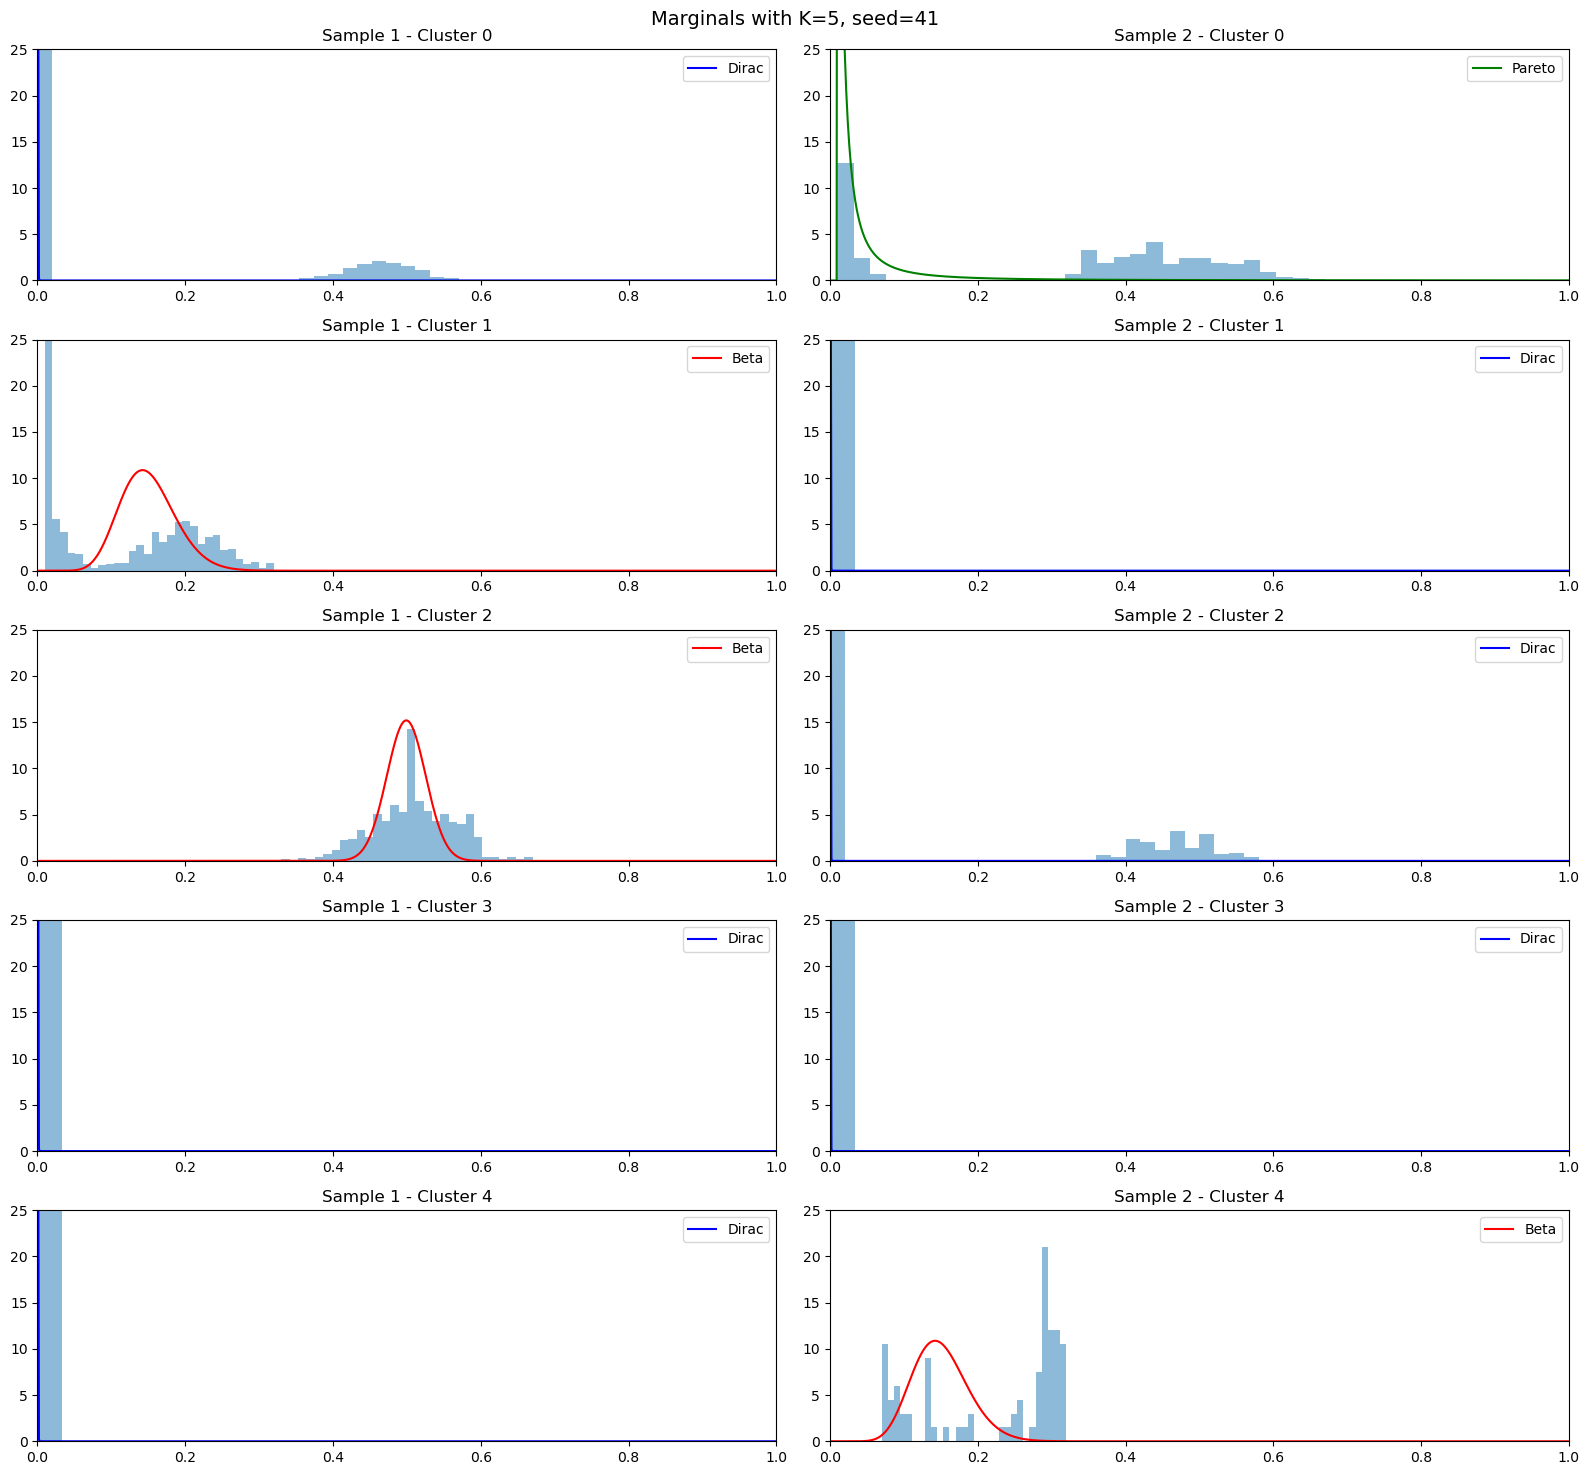

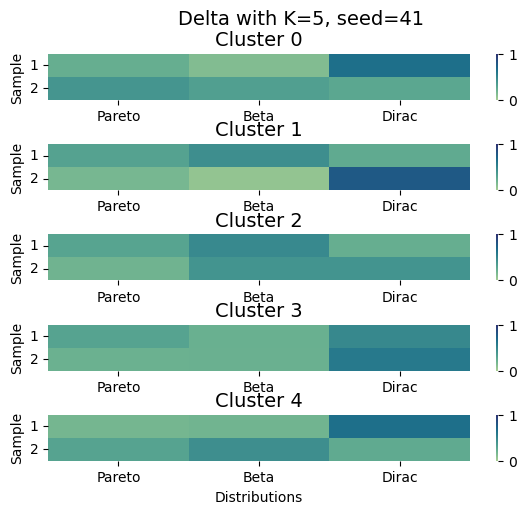

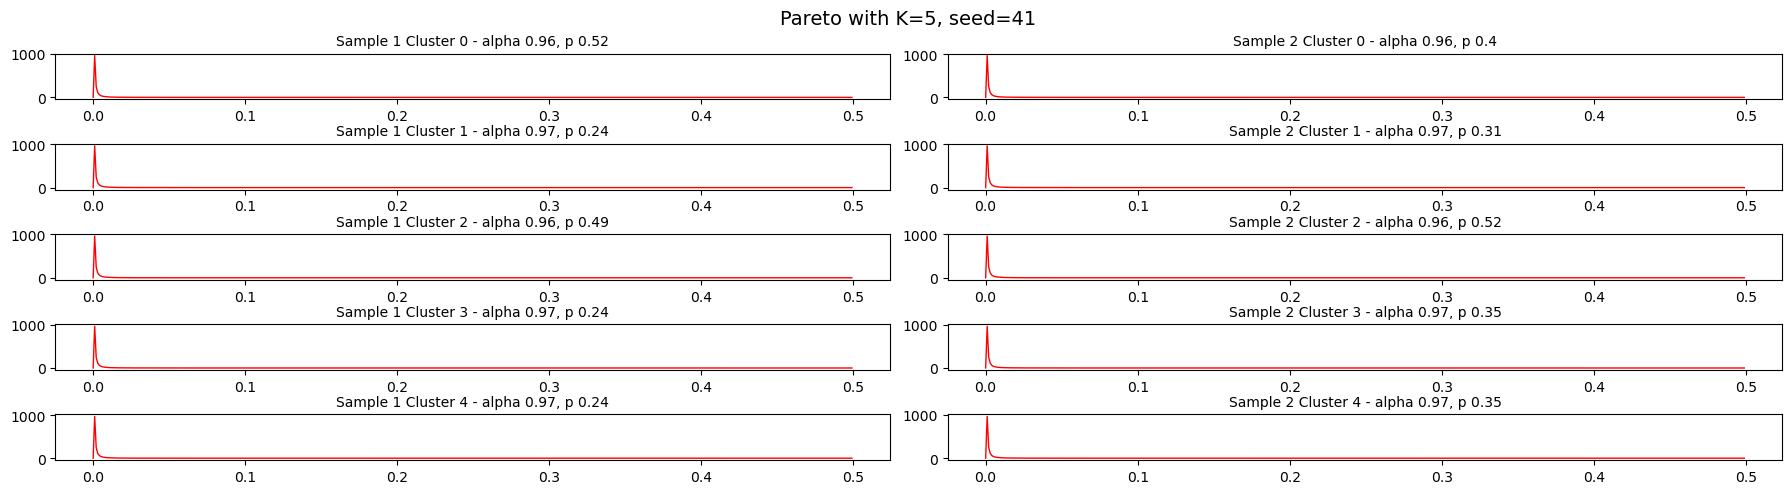

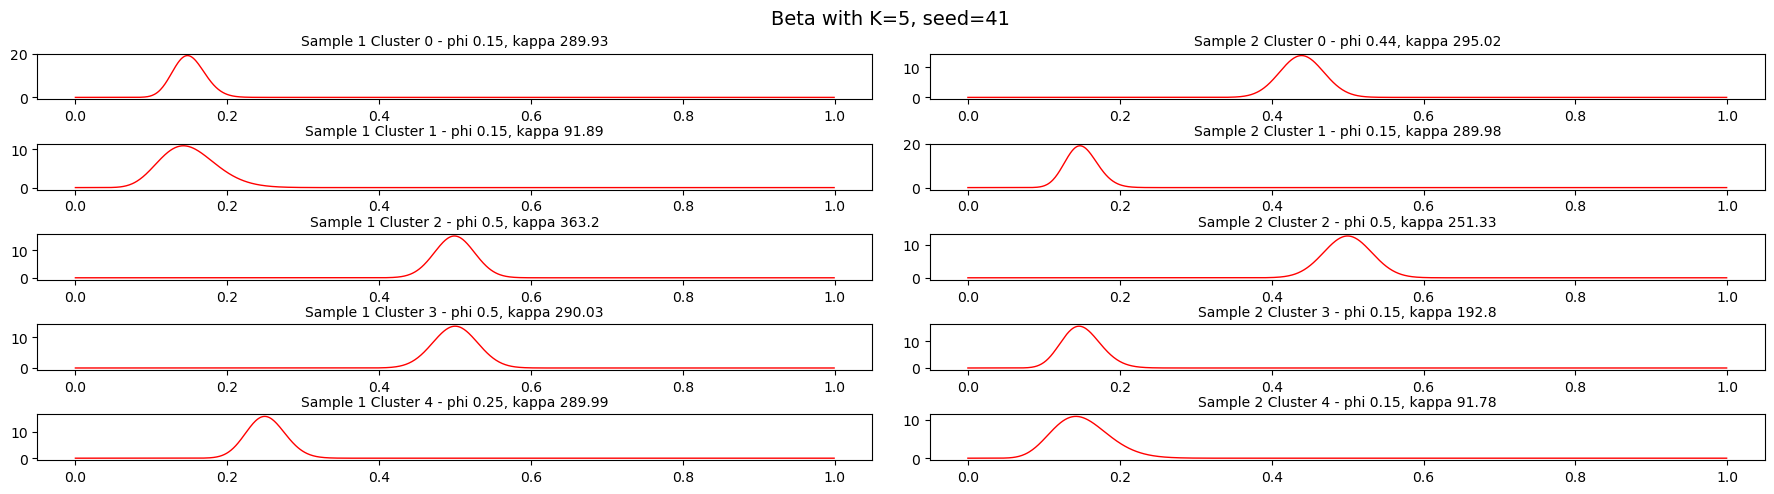

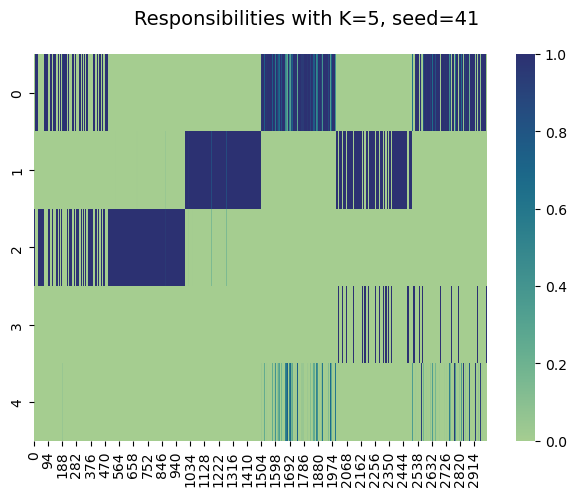

Selected number of clusters is 5 with seed 41


In [16]:
K_list = [5]
seed_list = [41]
mb_list, best_K, best_seed = model_mobster_mv.fit(NV, DP, num_iter = 2000, K = K_list, seed = seed_list, lr = 0.01)

In [18]:
NV[np.where(mb_list[0].params['cluster_assignments'] == 3)]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

### rRACES longitudinal data

In [3]:
NV_r = pd.read_csv("./rRACES_data/NV_long.csv")
DP_r = pd.read_csv("./rRACES_data/DP_long.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([1224, 2])
torch.Size([1224, 2])


In [4]:
torch.sum((NV[:,0]/DP[:,0] < 0.15) & (NV[:,0]/DP[:,0] > 0.))

tensor(424)

In [5]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0094)
tensor(0.0095)


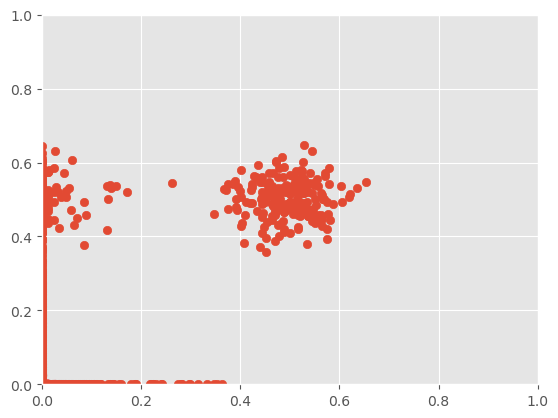

In [6]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

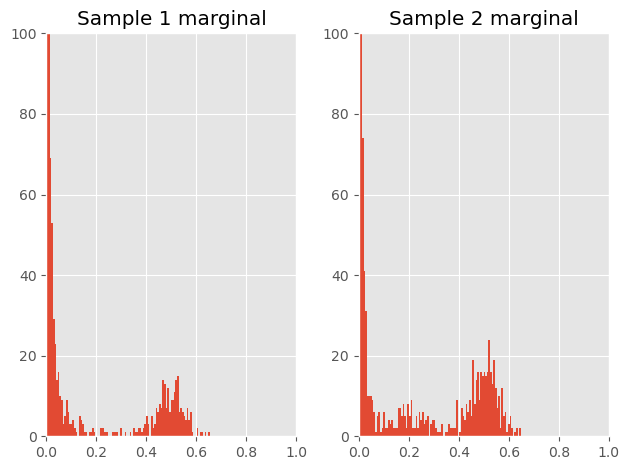

In [7]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 100)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 100)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[1.4442e-02, 1.1785e-02],
        [4.9358e-01, 5.0280e-01],
        [1.6109e-02, 4.9525e-01],
        [2.2913e-01, 1.4901e-08],
        [1.4901e-08, 2.1557e-01]])


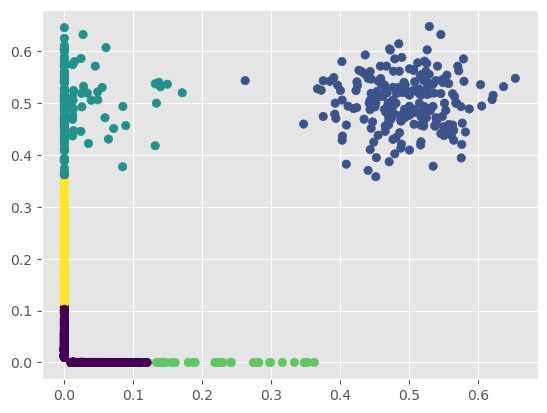

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

RUN WITH K = 5 AND SEED = 40
NV = 0 before: tensor(965)
NV = 0 after: tensor(965)
delta_param tensor([[[0.3992, 0.6008],
         [0.4028, 0.5972]],

        [[0.6042, 0.3958],
         [0.4042, 0.5958]],

        [[0.4043, 0.5957],
         [0.4042, 0.5958]],

        [[0.3960, 0.6040],
         [0.4044, 0.5956]],

        [[0.3960, 0.6040],
         [0.6040, 0.3960]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 9667181.218276024
Iteration 200: Loss = 8378602.860245705
Iteration 400: Loss = 8563805.271439552
Iteration 600: Loss = 8667509.96601963
Iteration 800: Loss = 7767619.638627052
Iteration 1000: Loss = 8016712.499466896
Iteration 1200: Loss = 8537165.956009865
Iteration 1400: Loss = 7348366.254349709
Iteration 1600: Loss = 7793398.791947365
Iteration 1800: Loss = 8820129.803177834
Iteration 2000: Loss = 8378946.28218174
Iteration 2200: Loss = 7546939.73921299
Iteration 2400: Loss = 8502245.992142677
Iteration 2600: Loss = 10284397.900345802
Iteration 2800: Loss = 7609825.866166

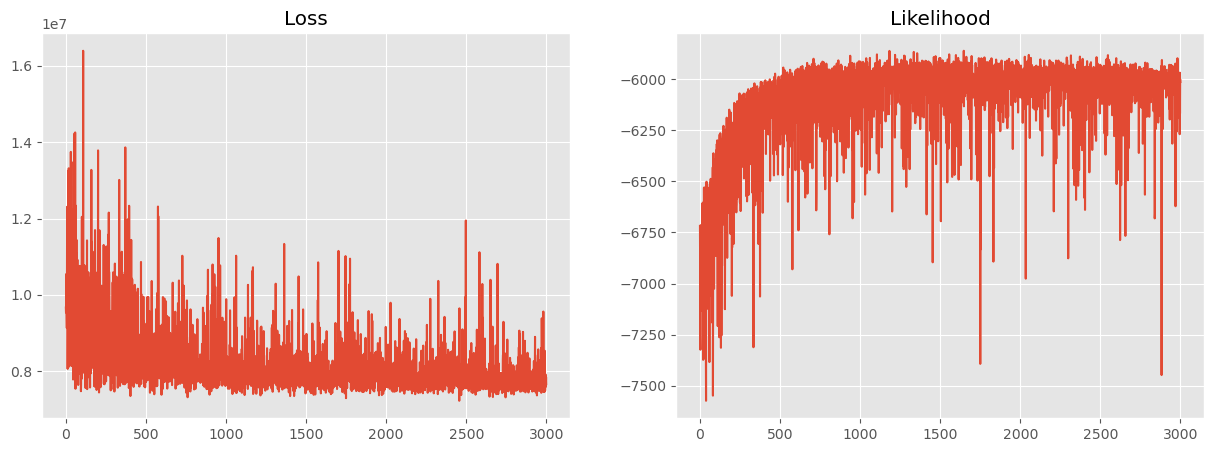

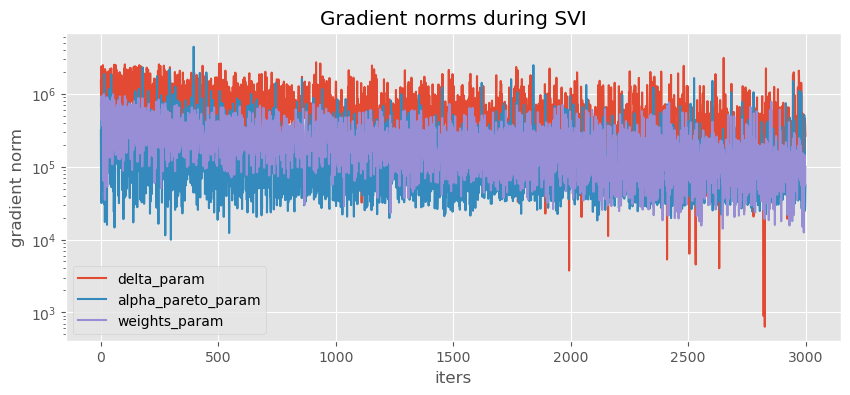

bic:  tensor(64942.1406, grad_fn=<RsubBackward1>)


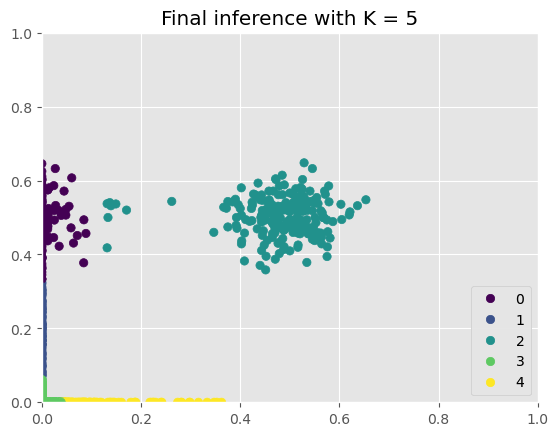

RUN WITH K = 5 AND SEED = 41
NV = 0 before: tensor(965)
NV = 0 after: tensor(965)
delta_param tensor([[[0.4040, 0.5960],
         [0.4040, 0.5960]],

        [[0.6042, 0.3958],
         [0.4006, 0.5994]],

        [[0.4026, 0.5974],
         [0.3960, 0.6040]],

        [[0.4042, 0.5958],
         [0.4042, 0.5958]],

        [[0.4043, 0.5957],
         [0.6042, 0.3958]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 11033636.230294228
Iteration 200: Loss = 10974478.94221592
Iteration 400: Loss = 9634997.9427042
Iteration 600: Loss = 8265647.926468849
Iteration 800: Loss = 7773214.20405674
Iteration 1000: Loss = 7816185.073197365
Iteration 1200: Loss = 7957319.63374424
Iteration 1400: Loss = 8803613.581986427
Iteration 1600: Loss = 7789709.794388771
Iteration 1800: Loss = 7510386.583939552
Iteration 2000: Loss = 7998164.67280674
Iteration 2200: Loss = 7841934.515091896
Iteration 2400: Loss = 7875140.988724709
Iteration 2600: Loss = 8569658.366654396
Iteration 2800: Loss = 7596627.97456455

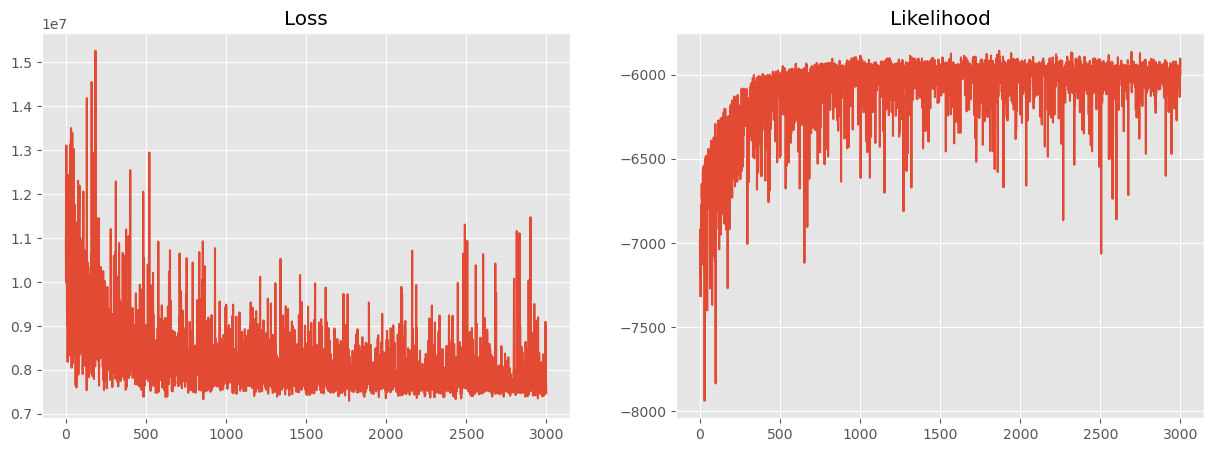

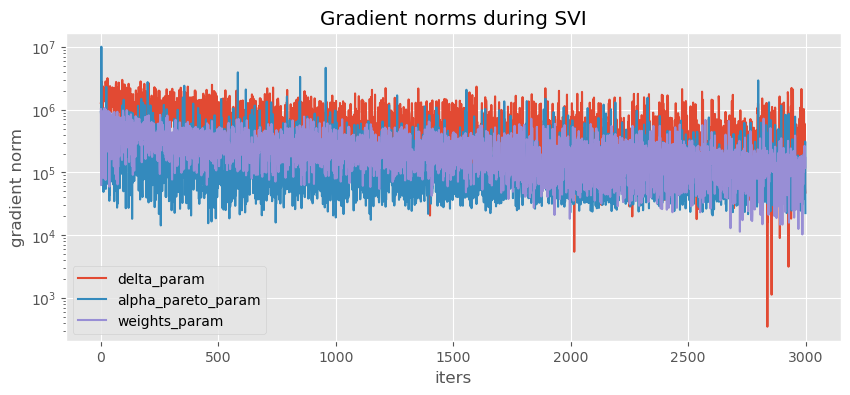

bic:  tensor(65110.6758, grad_fn=<RsubBackward1>)


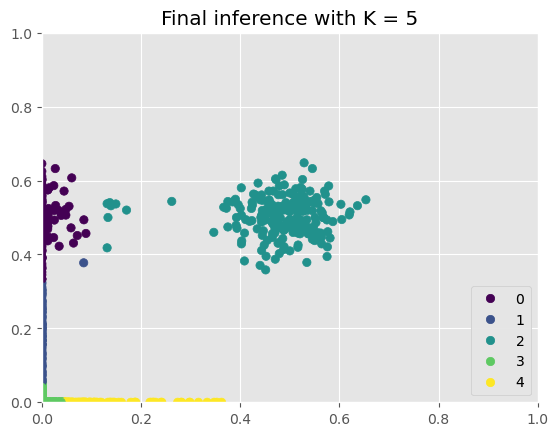

RUN WITH K = 5 AND SEED = 42
NV = 0 before: tensor(965)
NV = 0 after: tensor(965)
delta_param tensor([[[0.4042, 0.5958],
         [0.4046, 0.5954]],

        [[0.6043, 0.3957],
         [0.3957, 0.6043]],

        [[0.4040, 0.5960],
         [0.3959, 0.6041]],

        [[0.4043, 0.5957],
         [0.4042, 0.5958]],

        [[0.4047, 0.5953],
         [0.6042, 0.3958]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 9547698.230294228
Iteration 200: Loss = 8044141.451737404
Iteration 400: Loss = 8200626.592972755
Iteration 600: Loss = 8386107.795365334
Iteration 800: Loss = 8181075.00483799
Iteration 1000: Loss = 10226915.952103615
Iteration 1200: Loss = 7611071.402787209
Iteration 1400: Loss = 7512190.507767677
Iteration 1600: Loss = 8614024.865189552
Iteration 1800: Loss = 7711670.040482521
Iteration 2000: Loss = 8751983.402298927
Iteration 2200: Loss = 7874595.66108799
Iteration 2400: Loss = 7529863.209427834
Iteration 2600: Loss = 7816502.931107521
Iteration 2800: Loss = 7566031.65522

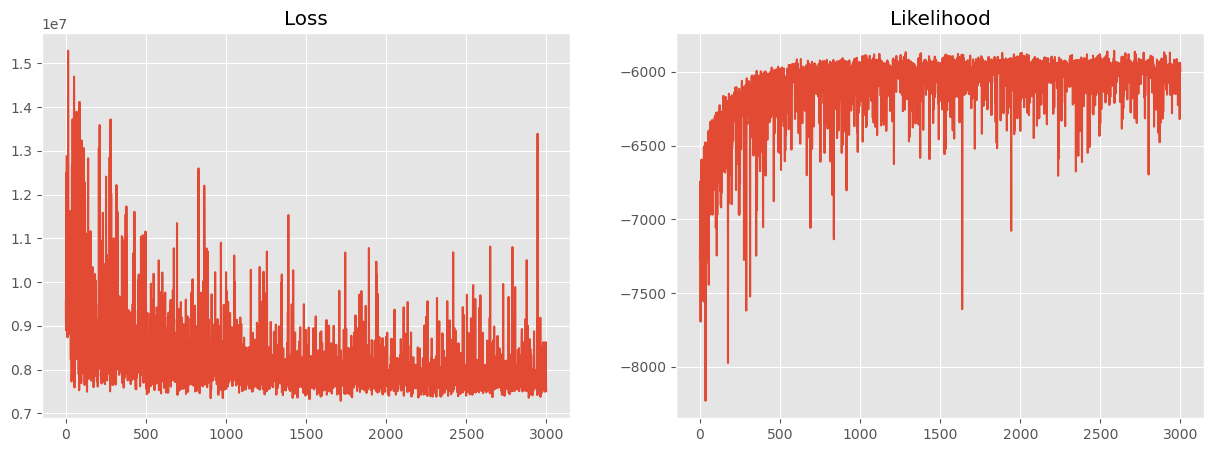

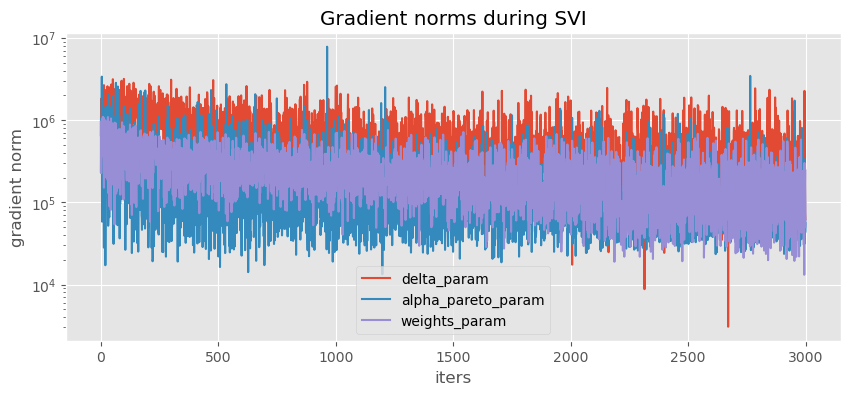

bic:  tensor(67924.7109, grad_fn=<RsubBackward1>)


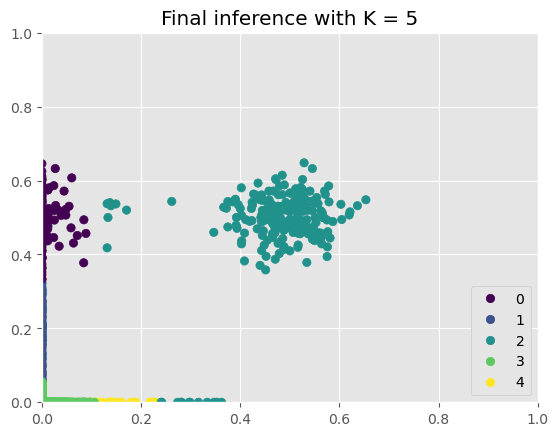

Selected number of clusters is 5 with seed 40


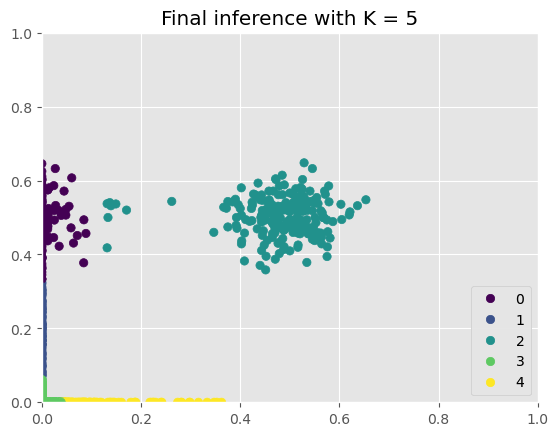

In [9]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [5], seed = [40,41,42], lr = 0.005)

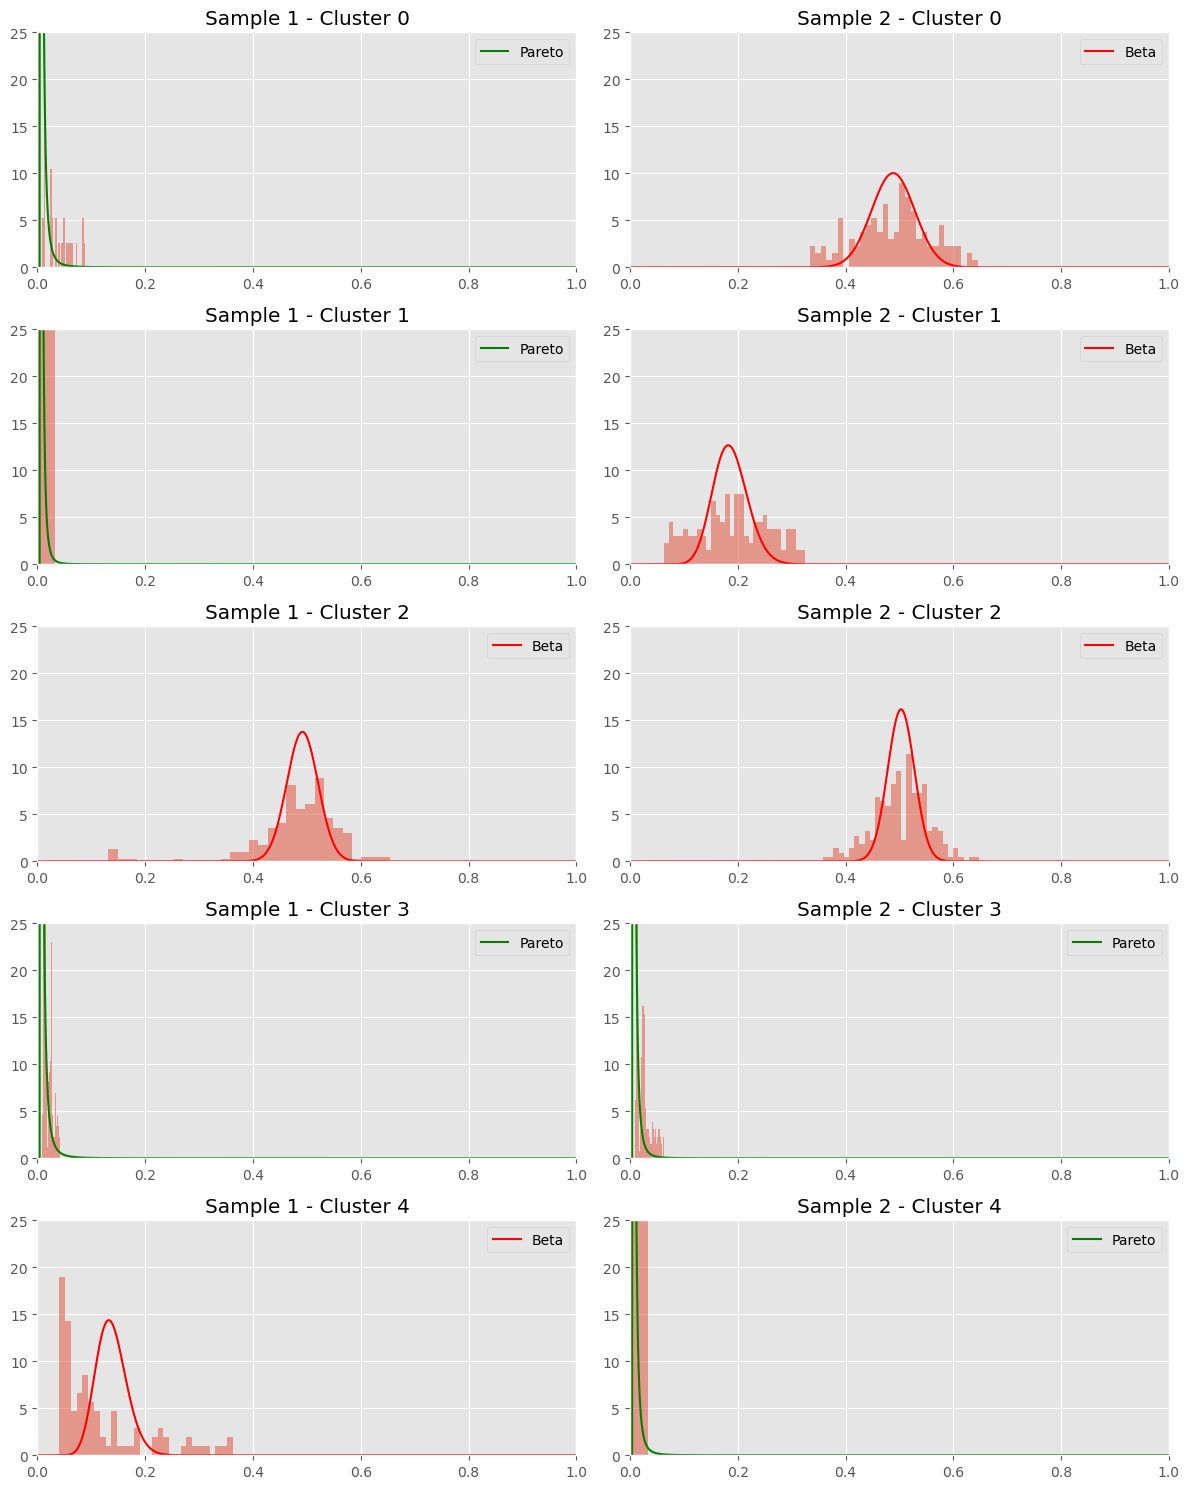

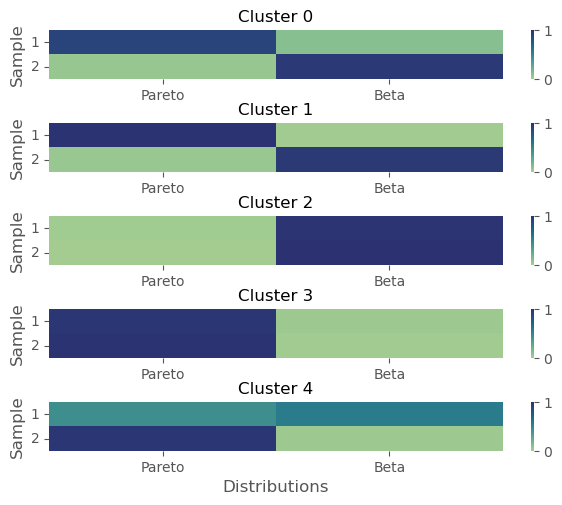

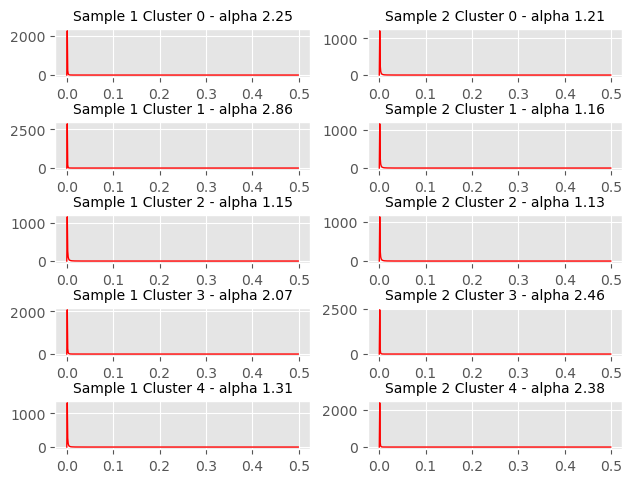

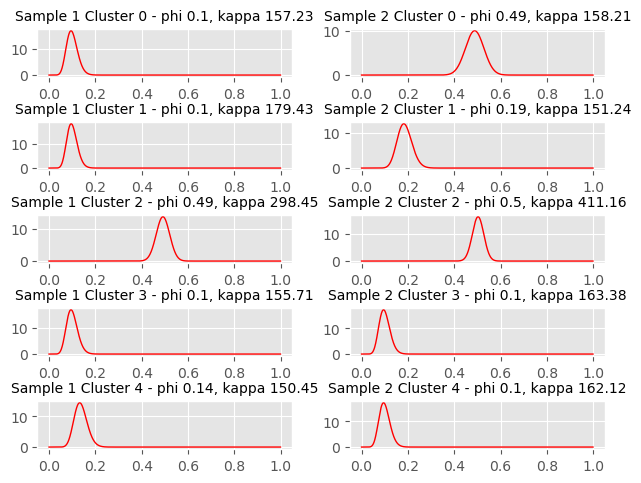

In [10]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [11]:
final_mb.params

{'weights_param': tensor([0.1144, 0.1352, 0.1816, 0.4390, 0.1298], dtype=torch.float64,
        grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[2.2464, 1.2096],
         [2.8588, 1.1572],
         [1.1535, 1.1251],
         [2.0691, 2.4609],
         [1.3089, 2.3770]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.1000, 0.4884],
         [0.1000, 0.1865],
         [0.4916, 0.5029],
         [0.1000, 0.1000],
         [0.1372, 0.1000]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[157.2252, 158.2113],
         [179.4272, 151.2379],
         [298.4548, 411.1562],
         [155.7134, 163.3846],
         [150.4542, 162.1190]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.8958, 0.1042],
          [0.0470, 0.9530]],
 
         [[0.9878, 0.0122],
          [0.0456, 0.9544]],
 
         [[0.0174, 0.9826],
          [0.0073, 0.9927]],
 
         [[0.9701, 0.0299],
          [0.9855, 0.0145]],
 
         [[0.4389, 0.5611],
          [0.9705, 0.0295]]], grad_fn=<Di